The Myers Briggs Type Indicator (or MBTI) is a personality type system that divides everyone into 16 distinct personality types across 4 axis:

Introversion (I) – Extroversion (E)

Intuition (N) – Sensing (S)

Thinking (T) – Feeling (F)

Judging (J) – Perceiving (P)


So for example, someone who prefers introversion, intuition, thinking and perceiving would be labelled an INTP in the MBTI system, and there are lots of personality based components that would model or describe this person’s preferences or behaviour based on the label.

From scientific or psychological perspective it is based on the work done on cognitive functions by Carl Jung i.e. Jungian Typology. This was a model of 8 distinct functions, thought processes or ways of thinking that were suggested to be present in the mind. Later this work was transformed into several different personality systems to make it more accessible, the most popular of which is of course the MBTI.

This dataset contains over 8600 rows of data, on each row is a person’s:

- Type (This persons 4 letter MBTI code/type)
- A section of each of the last 50 things they have posted (Each entry separated by "|||" (3 pipe characters))

## Importing all the necessary libraries

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import re
import string
import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from tqdm import tqdm
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import class_weight
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn import preprocessing

import tweepy
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sb
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

!pip install catboost
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/mbti_1.csv")
df.head()

type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...

### Checking for the null values

In [ ]:
df.isnull().any()

type     False
posts    False
dtype: bool

In [ ]:
df.shape

(8675, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [ ]:
types = np.unique(np.array(df['type']))
types

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64


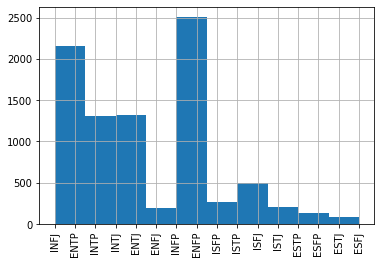

In [ ]:
print(df.type.value_counts())
df.type.hist(xrot=90)
plt.show()

### Distribution of different personality types based on their frequencies in the dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



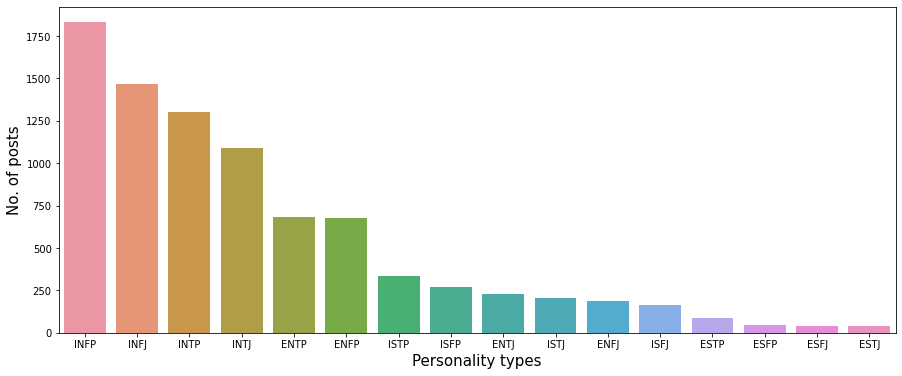

In [ ]:
graph = df['type'].value_counts()
plt.figure(figsize=(15,6))
sb.barplot(graph.index, graph.values, alpha=1)
plt.xlabel('Personality types', fontsize=15)
plt.ylabel('No. of posts', fontsize=15)
plt.show()

-> Above plot shows INFP type personalities are most common in our dataset, while ESTJ are least

-> Now analysis based on each user's pattern of tweets is performed

In [ ]:
df1 = df.copy()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning:

64.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning:

39.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning:

60.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning:

54.0% of the points cannot be placed; you may w

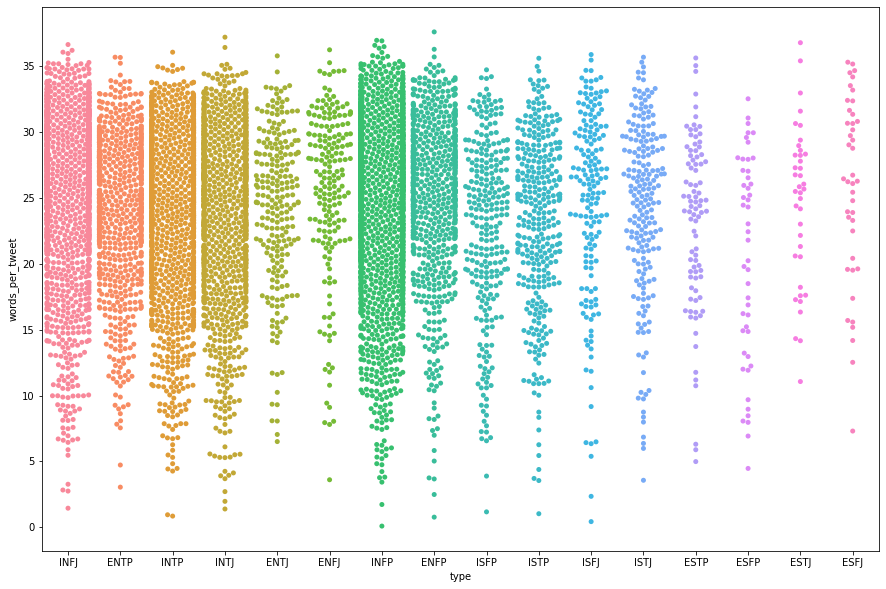

In [ ]:
# Swarm Plot
#this function counts the no of words in each post of a user
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)

#this function counts the no of words per post out of the total 50 posts in the whole row
df1['words_per_tweet'] = df1['posts'].apply(lambda x: len(x.split())/50)
df1['variance_of_word_counts'] = df1['posts'].apply(lambda x: var_row(x))

plt.figure(figsize=(15,10))
sb.swarmplot("type", "words_per_tweet", data=df1)

In [ ]:
df1.head()

type  ... variance_of_word_counts
0  INFJ  ...                135.2900
1  ENTP  ...                187.4756
2  INTP  ...                180.6900
3  INTJ  ...                181.8324
4  ENTJ  ...                196.4576

[5 rows x 4 columns]

-> Now wordcloud based on 40 most common words in all posts is generated

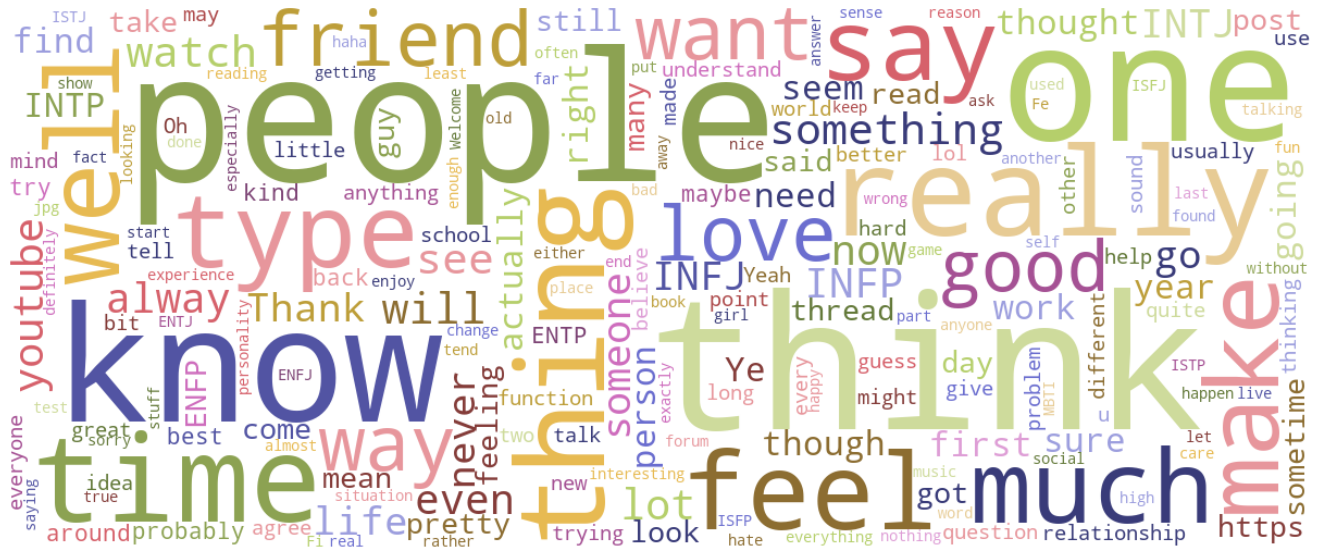

In [ ]:
#Plotting WordCloud.

#Finding the most common words in all posts.
words = list(df1["posts"].apply(lambda x: x.split()))
words = [x for y in words for x in y]
Counter(words).most_common(40)
wc = wordcloud.WordCloud(width=1200, height=500, 
                         collocations=False, background_color="white", 
                         colormap="tab20b").generate(" ".join(words))

# collocations to False  is set to ensure that the word cloud doesn't appear as if it contains any duplicate words
plt.figure(figsize=(25,10))
# generate word cloud, interpolation 
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

-> 5 most common words from above figure are:-
- people
- think
- one
- know
- really

-> Now subplots of wordcloud corresponding to most frequent words in each of the 16 different personalities are generated

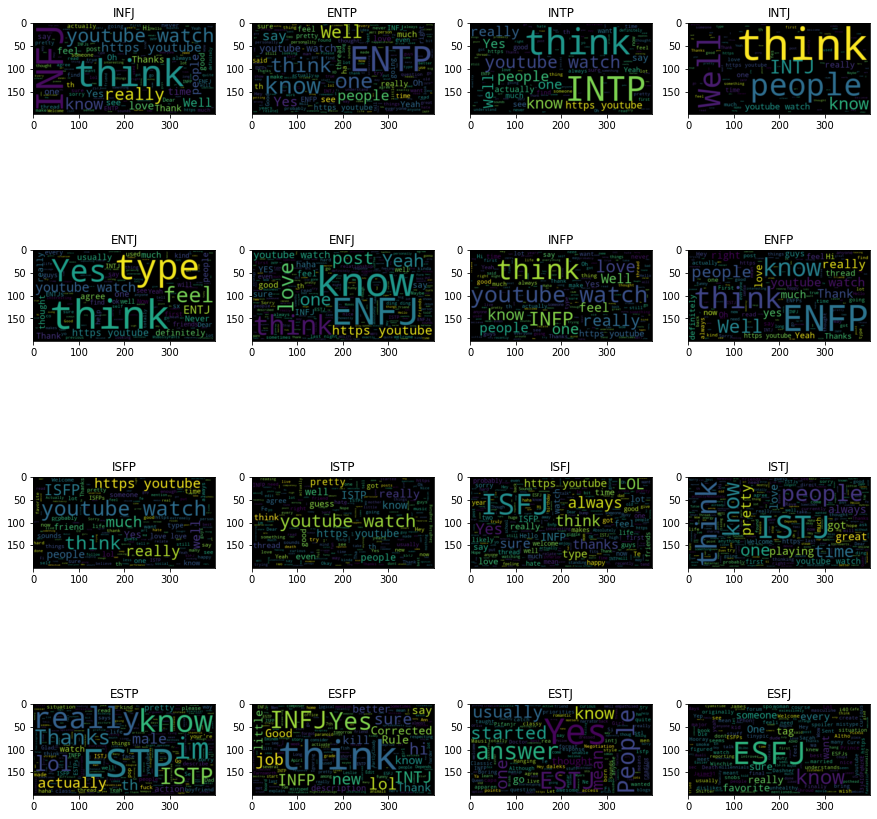

In [ ]:
fig, ax = plt.subplots(len(df1['type'].unique()), sharex=True, figsize=(15,len(df1['type'].unique())))
k = 0
for i in df1['type'].unique():
    df_4 = df[df['type'] == i]
    wordcloud = WordCloud(max_words=1628,relative_scaling=1,normalize_plurals=False).generate(df_4['posts'].to_string())
    plt.subplot(4,4,k+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i)
    ax[k].axis("off")
    k+=1

### -> Adding one column for each MBTI characteristic pair, since we will be training independent classifier model for each pair independently. The reason for this is because of imbalance present in our dataset as seen in the EDA section.

In [ ]:
df['ie'] = df.type
df['ns'] = df.type
df['ft'] = df.type
df['pj'] = df.type

for i, t in enumerate(df.type):
    if 'I' in t:
        df.ie[i] = 'I'
    elif 'E' in t:
        df.ie[i] = 'E'
        
    if 'N' in t:
        df.ns[i] = 'N'
    elif 'S' in t:
        df.ns[i] = 'S'
        
    if 'F' in t:
        df.ft[i] = 'F'
    elif 'T' in t:
        df.ft[i] = 'T'
        
    if 'P' in t:
        df.pj[i] = 'P'
    elif 'J' in t:
        df.pj[i] = 'J'


posts = df.posts.values
yIE = df.ie.values
yNS = df.ns.values
yFT = df.ft.values
yPJ = df.pj.values
y = df.type

In [ ]:
posts.shape

(8675,)

In [ ]:
df.head()

type                                              posts ie ns ft pj
0  INFJ  moment sportscenter top ten play experience re...  I  N  F  J
1  ENTP  finding lack post boring position often exampl...  E  N  T  P
2  INTP  one course say blessing absolutely positive be...  I  N  T  P
3  INTJ  enjoyed conversation day esoteric gabbing natu...  I  N  T  J
4  ENTJ  another silly misconception approaching logica...  E  N  T  J

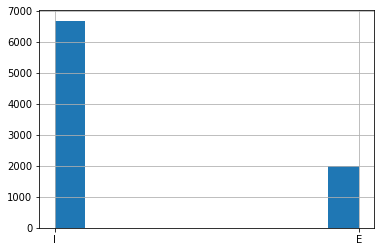

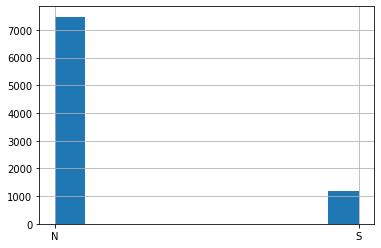

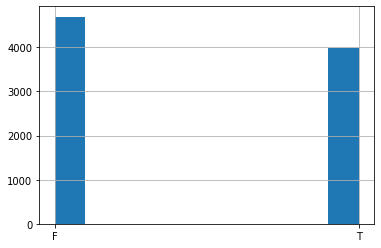

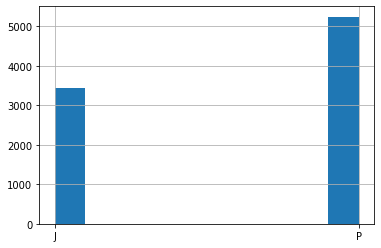

In [ ]:
df.ie.hist(); plt.show()
df.ns.hist(); plt.show()
df.ft.hist(); plt.show()
df.pj.hist(); plt.show()

-> Above we can see that there is great unbalance in Introvert/Extrovert and Intuition/Sensing pairs. Whereas Feeling/Thinking and Perception/Judgment pairs are quite balanced.

How many Introvert posts are present v/s how many Extrovert posts are presnt, out of all the given entries in our labelled Kaggle dataset. This is done in order to explore the dataset for all the individual Personality Indices of MBTI

Counting No. of posts in one class / Total no. of posts in the other class

In [ ]:
print ("Introversion (I) /  Extroversion (E):\t", df['ie'].value_counts()['I'], " / ", df['ie'].value_counts()['E'])
print ("Intuition (N) / Sensing (S):\t\t", df['ns'].value_counts()['N'], " / ", df['ns'].value_counts()['S'])
print ("Thinking (T) / Feeling (F):\t\t", df['ft'].value_counts()['F'], " / ", df['ft'].value_counts()['T'])
print ("Judging (J) / Perceiving (P):\t\t", df['pj'].value_counts()['P'], " / ", df['pj'].value_counts()['J'])

Introversion (I) /  Extroversion (E):	 6676  /  1999
Intuition (N) / Sensing (S):		 7478  /  1197
Thinking (T) / Feeling (F):		 4694  /  3981
Judging (J) / Perceiving (P):		 5241  /  3434


### -> Now data preprocessing is performed using regular expressions

In [ ]:
#regular expressions for tokenization
regexes = [
    #urls
    #r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',
    
    #html
    #r'<[^>]+>',
    
    #punctuation
    r'(?:(\w+)\'s)',
    
    r'(?:\s(\w+)\.+\s)',
    r'(?:\s(\w+),+\s)',
    r'(?:\s(\w+)\?+\s)',
    r'(?:\s(\w+)!+\s)',
    
    r'(?:\'+(\w+)\'+)',
    r'(?:"+(\w+)"+)',
    r'(?:\[+(\w+)\]+)',
    r'(?:{+(\w+)}+)',
    r'(?:\(+(\w+))',
    r'(?:(\w+)\)+)',

    #words containing numbers & special characters & punctuation
    r'(?:(?:(?:[a-zA-Z])*(?:[0-9!"#$%&\'()*+,\-./:;<=>?@\[\\\]^_`{|}~])+(?:[a-zA-Z])*)+)',
    
    #pure words
    r'([a-zA-Z]+)',
    
    #numbers
    #r'(?:(?:\d+,?)+(?:\.?\d+)?)',

    #emoticons
    #r"""(?:[:=;][oO\-]?[D\)\]\(\]/\\OpP])""",

    #other words
    #r'(?:[\w_]+)',

    #anything else
    #r'(?:\S)'
]

#compiling regular expression
regex = re.compile(r'(?:'+'|'.join(regexes)+')', re.VERBOSE | re.IGNORECASE)

-> Functions like tokenization, lemmatization and stopwords removal is performed

In [ ]:

def preprocess(documents):
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    
    #fetching list of stopwords
    punctuation = list(string.punctuation)
    swords = stopwords.words('english') + ['amp'] + ['infp', 'infj', 'intp', 'intj', 'isfp', 'isfj', 'enfp', 'enfj', 'entp', 'entj', 'esfp', 'esfj', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'january', 'feburary', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december',  'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun',  'jan', 'feb', 'mar', 'apr', 'may', 'jun' 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'tommorow', 'today', 'yesterday'] + ['mr', 'mrs']


    processed_documents = []
    for i,document in enumerate(documents):
        print('{0}/{1}'.format(i+1, len(documents)))
        
        #tokenization
        tokens = regex.findall(document)

        #skipping useless tokens
        t_regex = re.compile(r"[^a-zA-Z]")
        document = []
        
        for token in tokens:
            token = np.array(token)
            token = np.unique(token[token != ''])
            
            if len(token) > 0:
                token = token[0].lower()
            else:
                continue
                
            if re.search(t_regex, token) == None and token not in swords:
                token = lemmatizer.lemmatize(token)
                document.append(token)
                
        document = ' '.join(document)

        #skipping
        if len(document) >= 0:
            processed_documents.append(document)

    print()
    return np.array(processed_documents)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
%%time
posts = preprocess(posts)

Streaming output truncated to the last 5000 lines.
3679/8675
3680/8675
3681/8675
3682/8675
3683/8675
3684/8675
3685/8675
3686/8675
3687/8675
3688/8675
3689/8675
3690/8675
3691/8675
3692/8675
3693/8675
3694/8675
3695/8675
3696/8675
3697/8675
3698/8675
3699/8675
3700/8675
3701/8675
3702/8675
3703/8675
3704/8675
3705/8675
3706/8675
3707/8675
3708/8675
3709/8675
3710/8675
3711/8675
3712/8675
3713/8675
3714/8675
3715/8675
3716/8675
3717/8675
3718/8675
3719/8675
3720/8675
3721/8675
3722/8675
3723/8675
3724/8675
3725/8675
3726/8675
3727/8675
3728/8675
3729/8675
3730/8675
3731/8675
3732/8675
3733/8675
3734/8675
3735/8675
3736/8675
3737/8675
3738/8675
3739/8675
3740/8675
3741/8675
3742/8675
3743/8675
3744/8675
3745/8675
3746/8675
3747/8675
3748/8675
3749/8675
3750/8675
3751/8675
3752/8675
3753/8675
3754/8675
3755/8675
3756/8675
3757/8675
3758/8675
3759/8675
3760/8675
3761/8675
3762/8675
3763/8675
3764/8675
3765/8675
3766/8675
3767/8675
3768/8675
3769/8675
3770/8675
3771/8675
3772/8675
3773/8675

In [ ]:
posts[0]

'moment sportscenter top ten play experience repeat perc experience immerse last thing friend posted facebook committing suicide next day rest sorry hear distress natural relationship perfection time every moment existence try figure hard time time growth game wellbrutin least thirty minute moving leg mean moving sitting desk chair weed moderation maybe try edible healthier come three item determined type whichever type want would likely use given cognitive function whatnot left thing moderation sims indeed video game good one good one somewhat subjective completely promoting death given favorite video game growing current favorite video game appears late someone thought confidence good cherish time solitude revel within inner world whereas time workin enjoy time worry people always around lady complimentary main social outlet xbox live conversation even verbally fatigue really dig part thread requires high backyard roast eat marshmellows backyard conversing something intellectual foll

-> Now adding the preprocessed posts back in the dataframe

In [ ]:
df['posts'] = posts
df.head(3)

type                                              posts ie ns ft pj
0  INFJ  moment sportscenter top ten play experience re...  I  N  F  J
1  ENTP  finding lack post boring position often exampl...  E  N  T  P
2  INTP  one course say blessing absolutely positive be...  I  N  T  P

## Cleaning and preprocessing of test data

In [5]:
test_df = pd.read_csv("/content/drive/MyDrive/Forbes figures mbti  - Sheet1.csv")
test_df.head()

Name  type                                              posts
0  Vladimir Putin  INTJ  Vladimir Putin met with Prime Minister of Arme...
1    Jeff Bezos\r  ISTJ  Welcome aboard, Michael!  This year’s grants g...
2    Pope Francis  ESFJ  I thank all those who are committed to allevia...
3      Bill Gates  INTP  I usually read a lot of non-fiction books, but...
4   Reed Hastings  ENTJ  Congratulations to Makhtar Diop on your histor...

In [6]:
test_df.drop('Name', axis=1, inplace= True)

### Visualizations on Test Data

In [8]:
test_df_male = test_df.iloc[:17,:]
test_df_female = test_df.iloc[18:,:]

In [9]:
test_df_male.head()

type                                              posts
0  INTJ  Vladimir Putin met with Prime Minister of Arme...
1  ISTJ  Welcome aboard, Michael!  This year’s grants g...
2  ESFJ  I thank all those who are committed to allevia...
3  INTP  I usually read a lot of non-fiction books, but...
4  ENTJ  Congratulations to Makhtar Diop on your histor...

In [ ]:
test_df_female.head()

type                                              posts
18  ENFJ  Congratulations to Makhtar Diop on your histor...
19  ESTJ  Happy Hanukkah! Sending my warmest wishes to t...
20  ENTJ  Grazie mille @fabfazio per l’ospitalità e l’in...
21  ENTJ  Factory ZERO, @GM’s first fully dedicated #EV ...
22  ISTJ  The EU &amp; its Member States will work hard ...

Males

INTJ    5
ISTJ    4
ESFJ    3
ENTJ    2
ISTP    1
INFP    1
INTP    1
Name: type, dtype: int64


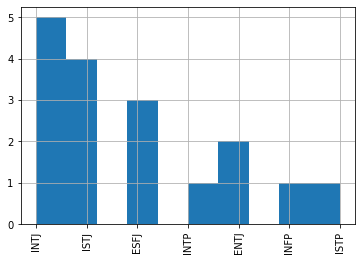

In [ ]:
print(test_df_male.type.value_counts())
test_df_male.type.hist(xrot=90)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



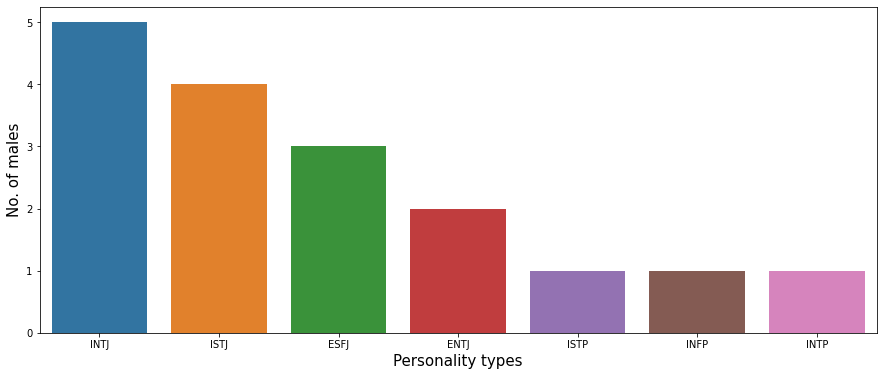

In [ ]:
graph = test_df_male['type'].value_counts()
plt.figure(figsize=(15,6))
sb.barplot(graph.index, graph.values, alpha=1)
plt.xlabel('Personality types', fontsize=15)
plt.ylabel('No. of males', fontsize=15)
plt.show()

Females

ENTJ    6
ENFJ    5
ESFJ    2
ISTJ    2
INTJ    1
ENFP    1
ESTJ    1
ISFP    1
Name: type, dtype: int64


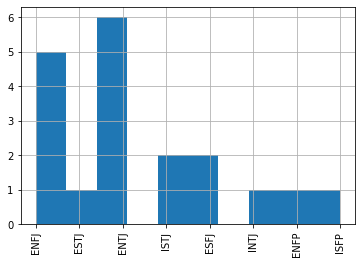

In [ ]:
print(test_df_female.type.value_counts())
test_df_female.type.hist(xrot=90)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



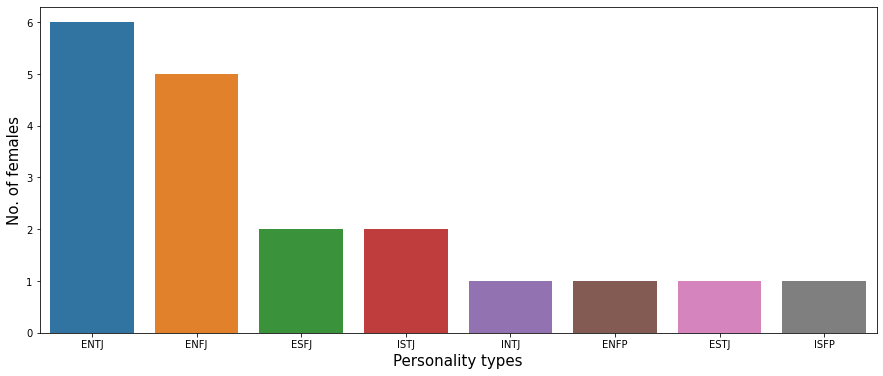

In [ ]:
graph = test_df_female['type'].value_counts()
plt.figure(figsize=(15,6))
sb.barplot(graph.index, graph.values, alpha=1)
plt.xlabel('Personality types', fontsize=15)
plt.ylabel('No. of females', fontsize=15)
plt.show()

### Preprocessing on Test Data

In [ ]:
test_df['ie'] = test_df.type
test_df['ns'] = test_df.type
test_df['ft'] = test_df.type
test_df['pj'] = test_df.type

for i, t in enumerate(test_df.type):
    if 'I' in t:
        test_df.ie[i] = 'I'
    elif 'E' in t:
        test_df.ie[i] = 'E'
        
    if 'N' in t:
        test_df.ns[i] = 'N'
    elif 'S' in t:
        test_df.ns[i] = 'S'
        
    if 'F' in t:
        test_df.ft[i] = 'F'
    elif 'T' in t:
        test_df.ft[i] = 'T'
        
    if 'P' in t:
        test_df.pj[i] = 'P'
    elif 'J' in t:
        test_df.pj[i] = 'J'


t_posts = test_df.posts.values
t_yIE = test_df.ie.values
t_yNS = test_df.ns.values
t_yFT = test_df.ft.values
t_yPJ = test_df.pj.values
t_y = test_df.type

In [ ]:
%%time
test_posts = test_df['posts']
test_posts = preprocess(test_posts)

1/37
2/37
3/37
4/37
5/37
6/37
7/37
8/37
9/37
10/37
11/37
12/37
13/37
14/37
15/37
16/37
17/37
18/37
19/37
20/37
21/37
22/37
23/37
24/37
25/37
26/37
27/37
28/37
29/37
30/37
31/37
32/37
33/37
34/37
35/37
36/37
37/37

CPU times: user 1.66 s, sys: 124 ms, total: 1.78 s
Wall time: 1.64 s


In [ ]:
test_posts[0]

'vladimir putin met prime minister armenia nikol pashinyan sochi leader russia azerbaijan armenia following trilateral talk ilham aliyev nikol pashinyan meeting president azerbaijan ilham aliyev vladimir putin visit india participant guest ceremony conclude year scientific technical innovative cooperation talk president serbia aleksandar vucic conversation european council president charles migration crisis belarusian border conflict government member vladimir putin talk president serbia aleksandar vucic arabia host meeting russia islamic world strategic vision group greeting president vladimir putin meet president azerbaijan ilham aliyev prime minister armenia nikol pashinyan vladimir putin met president palestine mahmoud abbas top agenda middle east macedonia declared mourning life lost bulgarian crash vladimir putin expressed condolence president stevo pendarovski conversation prime minister italy mario gas supply europe development ukraine migration crisis head federal taxation ser

In [ ]:
test_df['posts'] = test_posts
test_df.head()

type                                              posts ie ns ft pj
0  INTJ  vladimir putin met prime minister armenia niko...  I  N  T  J
1  ISTJ  welcome aboard year grant go group led expert ...  I  S  T  J
2  ESFJ  thank committed alleviating suffering let u re...  E  S  F  J
3  INTP  usually read lot book lately found drawn back ...  I  N  T  P
4  ENTJ  congratulation makhtar diop historic appointme...  E  N  T  J

### Preprocessing using tf-idf

TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency. This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction.

In TfidfVectorizer we consider overall document weightage of a word. It helps us in dealing with most frequent words. Using it we can penalize them. TfidfVectorizer weights the word counts by a measure of how often they appear in the documents.

In [ ]:
%%time

#TF-IDF representation
# creating document frequency matrix
cv = CountVectorizer(analyzer="word", max_features=150).fit(posts)
X = cv.transform(posts)

CPU times: user 8.18 s, sys: 29.1 ms, total: 8.21 s
Wall time: 9.75 s


In [ ]:
tf = TfidfTransformer()
X_tf=  tf.fit_transform(X).toarray()

In [ ]:
posts.shape, X.shape, X_tf.shape, yIE.shape, yNS.shape # verifying that the shapes match

((8675,), (8675, 1500), (8675, 1500), (8675,), (8675,))

In [ ]:
%%time

#TF-IDF representation
# creating document frequency matrix
cv = CountVectorizer(analyzer="word", max_features=150).fit(test_posts)
X_test_cnt = cv.transform(test_posts)

CPU times: user 47.1 ms, sys: 893 µs, total: 48 ms
Wall time: 48.3 ms


In [ ]:
X_test_tf=  tf.fit_transform(X_test_cnt).toarray()

In [ ]:
t_posts.shape, X_test_cnt.shape, X_test_tf.shape, t_yIE.shape, t_yNS.shape # verifying that the shapes match

((37,), (37, 1500), (37, 1500), (37,), (37,))

## Training and testing data

In [ ]:
xTrain = X_tf
yTrain = y

In [ ]:
xTest = X_test_tf
yTest = t_y

In [ ]:
xIETrain = X_tf
yIETrain = yIE

xNSTrain = X_tf
yNSTrain = yNS

xFTTrain = X_tf
yFTTrain = yFT

xPJTrain = X_tf
yPJTrain = yPJ

In [ ]:
xIETest = X_test_tf
yIETest = t_yIE

xNSTest = X_test_tf
yNSTest = t_yNS

xFTTest = X_test_tf
yFTTest = t_yFT

xPJTest = X_test_tf
yPJTest = t_yPJ

## Label Encoding

In [ ]:
frames = [df, test_df]
result = pd.concat(frames)

In [ ]:

le = preprocessing.LabelEncoder()
result['type'] = le.fit_transform(result.type.values)

In [ ]:
result.ie= le.fit_transform(result.ie.values)
result.ns= le.fit_transform(result.ns.values)
result.ft= le.fit_transform(result.ft.values)
result.pj= le.fit_transform(result.pj.values)

In [ ]:
result.head(4)

type                                              posts  ie  ns  ft  pj
0     8  moment sportscenter top ten play experience re...   1   0   0   0
1     3  finding lack post boring position often exampl...   0   0   1   1
2    11  one course say blessing absolutely positive be...   1   0   1   1
3    10  enjoyed conversation day esoteric gabbing natu...   1   0   1   0

In [ ]:
df_1 = result.iloc[:8675,:]
df_2 = result.iloc[8675:,:]

Label encoding type column of train data

Label encoding type column of test data

In [ ]:
nyTrain = df_1['type']
nyTest = df_2['type']

label encoding ie, ns, ft, pj column of train data


In [ ]:
yIE = df_1.ie
yNS = df_1.ns
yFT = df_1.ft
yPJ = df_1.pj

label encoding ie, ns, ft, pj column of test data


In [ ]:
t_yIE = df_2.ie
t_yNS = df_2.ns
t_yFT = df_2.ft
t_yPJ = df_2.pj

#**1. Multinomial NB**

In [ ]:
model = MultinomialNB().fit(xTrain, nyTrain)
ieModel = MultinomialNB().fit(xIETrain, yIE)
nsModel = MultinomialNB().fit(xNSTrain, yNS)
ftModel = MultinomialNB().fit(xFTTrain, yFT)
pjModel = MultinomialNB().fit(xPJTrain, yPJ)

In [ ]:
model.score(xTrain, nyTrain)

0.38420749279538907

In [ ]:
print(model.score(xTest, nyTest))
print(ieModel.score(xIETest, t_yIE))
print(nsModel.score(xNSTest, t_yNS))
print(ftModel.score(xFTTest, t_yFT))
print(pjModel.score(xPJTest, t_yPJ))

0.02702702702702703
0.43243243243243246
0.5945945945945946
0.5675675675675675
0.13513513513513514


As we can see above the first model which tries to predict at at once performs poorly. But the separate model which predicts i or e, n or s, f or t, p or j does good



To get actual performance of our models, I am using KFold cross validation with k=10 to get actual performance. These values will be pickled along with models, so that these can be used in scripts to allow users to see performance and reliability of each model corresponding to their characteristic pair.

In [ ]:
scores = []

scores.append(cross_val_score(estimator=model, cv=10, X=xTrain, y=nyTrain, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=10, X=xTrain, y=yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=10, X=xTrain, y=yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=10, X=xTrain, y=yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=10, X=xTrain, y=yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.34224934755685965
0.010999506858921941

0.7695677132333009
0.00032670269741515243

0.862017444548977
0.0004801584863242166

0.758616368748638
0.009614235427172763

0.6360814344713217
0.005228929099955184



In [ ]:
scores = []

scores.append(cross_val_score(estimator=model, cv=5, X=xTest, y=nyTest, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTest, y=t_yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTest, y=t_yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTest, y=t_yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTest, y=t_yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.25
0.14594869101216107

0.5178571428571429
0.07659860924831148

0.625
0.13923991921155665

0.65
0.05601566836199331

0.8642857142857142
0.008748177652797088



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



In [ ]:
print('Train Classification Report \n ',classification_report(nyTrain,model.predict(xTrain)))

Train Classification Report 
                precision    recall  f1-score   support

           0       0.00      0.00      0.00       190
           1       1.00      0.02      0.04       675
           2       0.00      0.00      0.00       231
           3       0.69      0.06      0.11       685
           4       0.00      0.00      0.00        42
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        39
           7       0.00      0.00      0.00        89
           8       0.42      0.42      0.42      1470
           9       0.32      0.90      0.47      1832
          10       0.63      0.29      0.39      1091
          11       0.48      0.54      0.51      1304
          12       0.00      0.00      0.00       166
          13       0.00      0.00      0.00       271
          14       0.00      0.00      0.00       205
          15       0.80      0.02      0.05       337

    accuracy                           0.38      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
print('Test Classification Report \n ',classification_report(nyTest,model.predict(xTest)))

Test Classification Report 
                precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         6
          11       0.08      1.00      0.14         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         1

    accuracy                           0.03        37
   macro avg       0.01      0.08      0.01        37
weighted avg       0.00      0.03      0.00        37



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control 

# **2. Logistic Regression**


In [ ]:
model_log=LogisticRegression(max_iter=3000,C=0.5,n_jobs=-1)

In [ ]:
model_lg = model_log.fit(xTrain, nyTrain)
ieModel = model_log.fit(xIETrain, yIE)
nsModel = model_log.fit(xNSTrain, yNS)
ftModel = model_log.fit(xFTTrain, yFT)
pjModel = model_log.fit(xPJTrain, yPJ)

In [ ]:
model_lg.score(xTrain, nyTrain)

0.5846685878962536

In [ ]:
model_lg.score(xTest, nyTest)

0.10810810810810811


In [ ]:
scores = []

scores.append(cross_val_score(estimator=model_lg, cv=5, X=xTrain, y=nyTrain, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTrain, y=yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTrain, y=yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTrain, y=yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTrain, y=yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.34224934755685965
0.010999506858921941

0.7695677132333009
0.00032670269741515243

0.862017444548977
0.0004801584863242166

0.758616368748638
0.009614235427172763

0.6360814344713217
0.005228929099955184



In [ ]:
scores = []

scores.append(cross_val_score(estimator=model_lg, cv=5, X=xTest, y=nyTest, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTest, y=t_yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTest, y=t_yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTest, y=t_yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTest, y=t_yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.25
0.14594869101216107

0.5178571428571429
0.07659860924831148

0.625
0.13923991921155665

0.65
0.05601566836199331

0.8642857142857142
0.008748177652797088



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



In [ ]:
print('Train Classification Report \n ',classification_report(nyTrain,model_lg.predict(xTrain)))

Train Classification Report 
                precision    recall  f1-score   support

           0       1.00      0.03      0.05       190
           1       0.74      0.37      0.49       675
           2       0.85      0.05      0.09       231
           3       0.70      0.43      0.54       685
           4       0.00      0.00      0.00        42
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        39
           7       0.64      0.08      0.14        89
           8       0.59      0.68      0.63      1470
           9       0.53      0.87      0.66      1832
          10       0.60      0.64      0.62      1091
          11       0.58      0.76      0.66      1304
          12       1.00      0.02      0.04       166
          13       1.00      0.03      0.06       271
          14       0.72      0.22      0.34       205
          15       0.75      0.49      0.59       337

    accuracy                           0.58      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
print('Test Classification Report \n ',classification_report(nyTest,model_lg.predict(xTest)))

Test Classification Report 
                precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.36      0.67      0.47         6
          11       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         1

    accuracy                           0.11        37
   macro avg       0.03      0.06      0.04        37
weighted avg       0.06      0.11      0.08        37



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control 

# **3. Random Forest**

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100)

In [ ]:
rnd_model =  RandomForestClassifier(n_estimators=100).fit(xTrain, nyTrain)
ieModel =  RandomForestClassifier(n_estimators=100).fit(xIETrain, yIE)
nsModel =  RandomForestClassifier(n_estimators=100).fit(xNSTrain, yNS)
ftModel =  RandomForestClassifier(n_estimators=100).fit(xFTTrain, yFT)
pjModel =  RandomForestClassifier(n_estimators=100).fit(xPJTrain, yPJ)

In [ ]:
rnd_model.score(xTrain, nyTrain)

0.9998847262247839

In [ ]:
print(rnd_model.score(xTest, nyTest))
print(ieModel.score(xIETest, t_yIE))
print(nsModel.score(xNSTest, t_yNS))
print(ftModel.score(xFTTest, t_yFT))
print(pjModel.score(xPJTest, t_yPJ))

0.10810810810810811
0.43243243243243246
0.5945945945945946
0.5945945945945946
0.21621621621621623


In [ ]:
scores = []

scores.append(cross_val_score(estimator=rnd_model, cv=5, X=xTrain, y=nyTrain, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTrain, y=yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTrain, y=yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTrain, y=yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTrain, y=yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.4119884726224784
0.00995234014715822

0.7721037463976945
0.001694171580022977

0.8622478386167147
0.0005155199948126407

0.7495100864553315
0.010780409374744162

0.6675504322766571
0.007491908615226228



In [ ]:
print('Train Classification Report \n ',classification_report(nyTrain,rnd_model.predict(xTrain)))

Train Classification Report 
                precision    recall  f1-score   support

           0       1.00      1.00      1.00       190
           1       1.00      1.00      1.00       675
           2       1.00      1.00      1.00       231
           3       1.00      1.00      1.00       685
           4       1.00      1.00      1.00        42
           5       1.00      1.00      1.00        48
           6       1.00      1.00      1.00        39
           7       1.00      1.00      1.00        89
           8       1.00      1.00      1.00      1470
           9       1.00      1.00      1.00      1832
          10       1.00      1.00      1.00      1091
          11       1.00      1.00      1.00      1304
          12       1.00      1.00      1.00       166
          13       1.00      1.00      1.00       271
          14       1.00      1.00      1.00       205
          15       1.00      1.00      1.00       337

    accuracy                           1.00      

#**4. K Nearest Neighbor**

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 5)

In [ ]:
knn_model =  KNeighborsClassifier(n_neighbors = 5).fit(xTrain, nyTrain)
ieModel = KNeighborsClassifier(n_neighbors = 5).fit(xIETrain, yIE)
nsModel =  KNeighborsClassifier(n_neighbors = 5).fit(xNSTrain, yNS)
ftModel =  KNeighborsClassifier(n_neighbors = 5).fit(xFTTrain, yFT)
pjModel =  KNeighborsClassifier(n_neighbors = 5).fit(xPJTrain, yPJ)

In [ ]:
knn_model.score(xTrain, nyTrain)

0.4896829971181556

In [ ]:
print(knn_model.score(xTest, nyTest))
print(ieModel.score(xIETest, t_yIE))
print(nsModel.score(xNSTest, t_yNS))
print(ftModel.score(xFTTest, t_yFT))
print(pjModel.score(xPJTest, t_yPJ))

0.08108108108108109
0.4864864864864865
0.6486486486486487
0.4594594594594595
0.1891891891891892


In [ ]:
scores = []

scores.append(cross_val_score(estimator=knn_model, cv=5, X=xTrain, y=nyTrain, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTrain, y=yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTrain, y=yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTrain, y=yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTrain, y=yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.25694524495677235
0.005274956167676101

0.7679538904899135
0.0028841489344546022

0.8464553314121037
0.008843835287062403

0.6350432276657061
0.01895684155450994

0.6220172910662825
0.004257333789652879



In [ ]:
print('Train Classification Report \n ',classification_report(nyTrain,knn_model.predict(xTrain)))

Train Classification Report 
                precision    recall  f1-score   support

           0       0.28      0.53      0.37       190
           1       0.41      0.52      0.46       675
           2       0.62      0.35      0.45       231
           3       0.52      0.39      0.44       685
           4       0.32      0.43      0.37        42
           5       0.43      0.12      0.19        48
           6       0.46      0.31      0.37        39
           7       0.61      0.51      0.55        89
           8       0.62      0.55      0.58      1470
           9       0.41      0.93      0.57      1832
          10       0.82      0.20      0.33      1091
          11       0.81      0.25      0.38      1304
          12       0.67      0.22      0.33       166
          13       0.82      0.10      0.18       271
          14       0.78      0.25      0.38       205
          15       0.52      0.61      0.56       337

    accuracy                           0.49      

#**KNN ||**

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)  

In [ ]:
knn_model =  KNeighborsClassifier(n_neighbors = 3).fit(xTrain, nyTrain)
ieModel = KNeighborsClassifier(n_neighbors = 3).fit(xIETrain, yIE)
nsModel =  KNeighborsClassifier(n_neighbors = 3).fit(xNSTrain, yNS)
ftModel =  KNeighborsClassifier(n_neighbors = 3).fit(xFTTrain, yFT)
pjModel =  KNeighborsClassifier(n_neighbors = 3).fit(xPJTrain, yPJ)

In [ ]:
knn_model.score(xTrain, nyTrain)

0.6396541786743516

In [ ]:
print(knn_model.score(xTest, nyTest))
print(ieModel.score(xIETest, t_yIE))
print(nsModel.score(xNSTest, t_yNS))
print(ftModel.score(xFTTest, t_yFT))
print(pjModel.score(xPJTest, t_yPJ))

0.0
0.43243243243243246
0.7297297297297297
0.4864864864864865
0.13513513513513514


In [ ]:
scores = []

scores.append(cross_val_score(estimator=knn_model, cv=5, X=xTrain, y=nyTrain, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTrain, y=yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTrain, y=yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTrain, y=yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTrain, y=yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.21671469740634003
0.004266687152350838

0.7625360230547551
0.006751147188171246

0.7971181556195965
0.032173569422369715

0.617521613832853
0.022157166922010807

0.6056484149855907
0.004896083131203536



#**KNN |||**

In [ ]:
knn_model =  KNeighborsClassifier(n_neighbors = 2).fit(xTrain, nyTrain)
ieModel = KNeighborsClassifier(n_neighbors = 2).fit(xIETrain, yIE)
nsModel =  KNeighborsClassifier(n_neighbors = 2).fit(xNSTrain, yNS)
ftModel =  KNeighborsClassifier(n_neighbors = 2).fit(xFTTrain, yFT)
pjModel =  KNeighborsClassifier(n_neighbors = 2).fit(xPJTrain, yPJ)

In [ ]:
knn_model.score(xTrain, nyTrain)

0.9742939481268011

In [ ]:
print(knn_model.score(xTest, nyTest))
print(ieModel.score(xIETest, t_yIE))
print(nsModel.score(xNSTest, t_yNS))
print(ftModel.score(xFTTest, t_yFT))
print(pjModel.score(xPJTest, t_yPJ))

0.02702702702702703
0.43243243243243246
0.5945945945945946
0.35135135135135137
0.13513513513513514


In [ ]:
scores = []

scores.append(cross_val_score(estimator=knn_model, cv=5, X=xTrain, y=nyTrain, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTrain, y=yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTrain, y=yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTrain, y=yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTrain, y=yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.21740634005763687
0.014077566446974771

0.7315273775216138
0.03805850583909355

0.8485302593659941
0.021247305275332657

0.5572334293948127
0.034697980789331666

0.5902017291066283
0.014640223279176044



# **5. CatBoost Classifier**

In [ ]:
model_cat=CatBoostClassifier(loss_function='MultiClass',eval_metric='MultiClass',task_type='GPU', verbose=False)

In [ ]:
cat =  model_cat.fit(xTrain, nyTrain)
ieModel = model_cat.fit(xIETrain, yIE)
nsModel =  model_cat.fit(xNSTrain, yNS)
ftModel =  model_cat.fit(xFTTrain, yFT)
pjModel =  model_cat.fit(xPJTrain, yPJ)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [ ]:
cat.score(xTrain, nyTrain)

0.09878962536023055

In [ ]:
print(cat.score(xTest, nyTest))
print(ieModel.score(xIETest, t_yIE))
print(nsModel.score(xNSTest, t_yNS))
print(ftModel.score(xFTTest, t_yFT))
print(pjModel.score(xPJTest, t_yPJ))

0.05405405405405406
0.4594594594594595
0.43243243243243246
0.5675675675675675
0.32432432432432434


In [ ]:
scores = []

scores.append(cross_val_score(estimator=cat, cv=5, X=xTrain, y=nyTrain, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTrain, y=yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTrain, y=yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTrain, y=yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTrain, y=yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.5137752161383287
0.01517328696737179

0.8093371757925073
0.006243966600092612

0.8820749279538905
0.007422413847610487

0.7940057636887607
0.007475928699523211

0.7243804034582133
0.009267896826393902



In [ ]:
print('Train Classification Report \n ',classification_report(nyTrain,model_cat.predict(xTrain)))

Train Classification Report 
                precision    recall  f1-score   support

           0       0.05      0.97      0.10       190
           1       0.13      1.00      0.23       675
           2       0.00      0.00      0.00       231
           3       0.00      0.00      0.00       685
           4       0.00      0.00      0.00        42
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        39
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00      1470
           9       0.00      0.00      0.00      1832
          10       0.00      0.00      0.00      1091
          11       0.00      0.00      0.00      1304
          12       0.00      0.00      0.00       166
          13       0.00      0.00      0.00       271
          14       0.00      0.00      0.00       205
          15       0.00      0.00      0.00       337

    accuracy                           0.10      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# **6. XGBoost**

In [ ]:
xgb = XGBClassifier()

In [ ]:
xgb_model =  xgb.fit(xTrain, nyTrain)
ieModel = xgb.fit(xIETrain, yIE)
nsModel =  xgb.fit(xNSTrain, yNS)
ftModel =  xgb.fit(xFTTrain, yFT)
pjModel =  xgb.fit(xPJTrain, yPJ)

In [ ]:
xgb_model.score(xTrain, nyTrain)

0.7176945244956773

In [ ]:
xgb_model.score(xTest, nyTest)

0.08108108108108109


In [ ]:
scores = []

scores.append(cross_val_score(estimator=xgb_model, cv=5, X=xTrain, y=nyTrain, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTrain, y=yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTrain, y=yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTrain, y=yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTrain, y=yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.25694524495677235
0.005274956167676101

0.7679538904899135
0.0028841489344546022

0.8464553314121037
0.008843835287062403

0.6350432276657061
0.01895684155450994

0.6220172910662825
0.004257333789652879



In [ ]:
print('Train Classification Report \n ',classification_report(nyTrain,xgb_model.predict(xTrain)))

Train Classification Report 
                precision    recall  f1-score   support

           0       0.99      0.71      0.82       190
           1       0.88      0.74      0.80       675
           2       0.99      0.78      0.88       231
           3       0.91      0.78      0.84       685
           4       1.00      0.76      0.86        42
           5       1.00      0.73      0.84        48
           6       1.00      0.85      0.92        39
           7       1.00      0.93      0.97        89
           8       0.84      0.82      0.83      1470
           9       0.73      0.92      0.81      1832
          10       0.81      0.81      0.81      1091
          11       0.83      0.84      0.83      1304
          12       1.00      0.76      0.86       166
          13       0.98      0.72      0.83       271
          14       0.93      0.90      0.92       205
          15       0.86      0.91      0.89       337

    accuracy                           0.83      

In [ ]:
model_xgb=XGBClassifier(gpu_id=0,tree_method='gpu_hist',max_depth=5,n_estimators=50,learning_rate=0.1)

In [ ]:
x_model =  model_xgb.fit(xTrain, nyTrain)
ieModel = model_xgb.fit(xIETrain, yIETrain)
nsModel =  model_xgb.fit(xNSTrain, yNSTrain)
ftModel =  model_xgb.fit(xFTTrain, yFTTrain)
pjModel =  model_xgb.fit(xPJTrain, yPJTrain)

In [ ]:
x_model.score(xTrain, nyTrain)

0.8308933717579251

In [ ]:
print(x_model.score(xTest, nyTest))

0.08108108108108109


In [ ]:
print('Train Classification Report \n ',classification_report(nyTrain,x_model.predict(xTrain)))

Train Classification Report 
                precision    recall  f1-score   support

           0       0.99      0.71      0.82       190
           1       0.88      0.74      0.80       675
           2       0.99      0.78      0.88       231
           3       0.91      0.78      0.84       685
           4       1.00      0.76      0.86        42
           5       1.00      0.73      0.84        48
           6       1.00      0.85      0.92        39
           7       1.00      0.93      0.97        89
           8       0.84      0.82      0.83      1470
           9       0.73      0.92      0.81      1832
          10       0.81      0.81      0.81      1091
          11       0.83      0.84      0.83      1304
          12       1.00      0.76      0.86       166
          13       0.98      0.72      0.83       271
          14       0.93      0.90      0.92       205
          15       0.86      0.91      0.89       337

    accuracy                           0.83      

#**7. Stochastic Gradient Descent (SGD)**

In [ ]:
sgd = SGDClassifier(max_iter=5, tol=None)

In [ ]:
sgd_model =  sgd.fit(xTrain, nyTrain)
ieModel = sgd.fit(xIETrain, yIE)
nsModel =  sgd.fit(xNSTrain, yNS)
ftModel =  sgd.fit(xFTTrain, yFT)
pjModel =  sgd.fit(xPJTrain, yPJ)

In [ ]:
sgd_model.score(xTrain, nyTrain)

0.0785014409221902

In [ ]:
print(sgd_model.score(xTest, nyTest))
print(ieModel.score(xIETest, t_yIE))
print(nsModel.score(xNSTest, t_yNS))
print(ftModel.score(xFTTest, t_yFT))
print(pjModel.score(xPJTest, t_yPJ))

0.05405405405405406
0.4594594594594595
0.6486486486486487
0.5135135135135135
0.3783783783783784


In [ ]:
scores = []

scores.append(cross_val_score(estimator=sgd_model, cv=5, X=xTrain, y=y, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTrain, y=yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTrain, y=yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTrain, y=yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTrain, y=yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.4651296829971182
0.011253224080106771

0.8074927953890491
0.00951270595309636

0.8710086455331412
0.008939479409955637

0.7650720461095102
0.0191389184725951

0.69164265129683
0.02588659925961015



In [ ]:
scores = []

scores.append(cross_val_score(estimator=sgd_model, cv=5, X=xTest, y=nyTest, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTest, y=t_yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTest, y=t_yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTest, y=t_yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTest, y=t_yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.11071428571428572
0.10618620533798932

0.5392857142857143
0.06813851438692468

0.4821428571428571
0.16288220358559113

0.6
0.12505101000008284

0.8142857142857143
0.09489521611133157



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



#**8. Support vector classification**

In [ ]:
svm = SVC(random_state = 1)

In [ ]:
svm_model =  svm.fit(xTrain, yTrain)
# ieModel =  svm.fit(xIETrain, yIETrain)
# nsModel =  svm.fit(xNSTrain, yNSTrain)
# ftModel =  svm.fit(xFTTrain, yFTTrain)
# pjModel =  svm.fit(xPJTrain, yPJTrain)

In [ ]:
svm_model.score(xTrain, yTrain)

0.8872622478386167

In [ ]:
print(svm_model.score(xTest, yTest))
# print(ieModel.score(xIETest, yIETest))
# print(nsModel.score(xNSTest, yNSTest))
# print(ftModel.score(xFTTest, yFTTest))
# print(pjModel.score(xPJTest, yPJTest))

0.08108108108108109


In [ ]:
print('Train Classification Report \n ',classification_report(yTrain,svm_model.predict(xTrain)))

Train Classification Report 
                precision    recall  f1-score   support

        ENFJ       1.00      0.43      0.60       190
        ENFP       0.96      0.85      0.90       675
        ENTJ       0.99      0.72      0.83       231
        ENTP       0.95      0.90      0.92       685
        ESFJ       1.00      0.36      0.53        42
        ESFP       0.00      0.00      0.00        48
        ESTJ       1.00      0.54      0.70        39
        ESTP       0.94      0.76      0.84        89
        INFJ       0.87      0.94      0.91      1470
        INFP       0.81      0.98      0.89      1832
        INTJ       0.90      0.93      0.91      1091
        INTP       0.90      0.96      0.93      1304
        ISFJ       1.00      0.49      0.66       166
        ISFP       1.00      0.59      0.74       271
        ISTJ       0.91      0.85      0.88       205
        ISTP       0.93      0.90      0.91       337

    accuracy                           0.89      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# **9. Linear SVC**

In [ ]:
yIE = df['ie']
yNS = df['ns']
yFT = df['ft']
yPJ = df['pj']

In [ ]:

model_linear_svc=LinearSVC(C=0.1)
# lscv =  model_linear_svc.fit(xTrain, nyTrain)
# ieModel = model_linear_svc.fit(xIETrain, yIE)
# nsModel =  model_linear_svc.fit(xNSTrain, yNS)
# ftModel =  model_linear_svc.fit(xFTTrain, yFT)
pjModel =  model_linear_svc.fit(xPJTrain, yPJ)

In [ ]:
print(lscv.score(xTrain, nyTrain))
print(lscv.score(xTest, nyTest))

0.3138904899135447
0.0


In [ ]:
print(lscv.score(xIETest, t_yIE))
print(lscv.score(xNSTest, t_yNS))
print(lscv.score(xFTTest, t_yFT))
print(lscv.score(xPJTest, t_yPJ))

0.6756756756756757
0.6486486486486487
0.5135135135135135
0.5945945945945946


In [ ]:
print('Train Classification Report \n ',classification_report(nyTrain,lscv.predict(xTrain)))

Train Classification Report 
                precision    recall  f1-score   support

           0       0.00      0.00      0.00       190
           1       0.29      0.07      0.12       675
           2       0.00      0.00      0.00       231
           3       0.25      0.05      0.08       685
           4       0.00      0.00      0.00        42
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        39
           7       0.00      0.00      0.00        89
           8       0.30      0.32      0.31      1470
           9       0.33      0.71      0.45      1832
          10       0.30      0.26      0.28      1091
          11       0.30      0.45      0.36      1304
          12       0.00      0.00      0.00       166
          13       0.17      0.00      0.01       271
          14       0.00      0.00      0.00       205
          15       0.60      0.03      0.05       337

    accuracy                           0.31      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
scores = []

# scores.append(cross_val_score(estimator=lscv, cv=5, X=xTrain, y=nyTrain, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTrain, y=yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTrain, y=yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTrain, y=yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTrain, y=yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.7707204610951008
0.0018729771538065507

0.8619020172910663
0.000587783229232608

0.6985590778097983
0.012297070066254344

0.6172910662824207
0.00804442481723015



In [ ]:
print('Train Classification Report \n ',classification_report(nyTest,lscv.predict(xTest)))

Train Classification Report 
                precision    recall  f1-score   support

           0       0.22      1.00      0.36         5
           1       0.07      1.00      0.13         1
           2       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         1

    accuracy                           0.16        37
   macro avg       0.03      0.18      0.04        37
weighted avg       0.03      0.16      0.05        37



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Prediction for Jacinda Ardern

In [ ]:
jacinda_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MBTI Project/jacindaardern_tweets - jacindaardern_tweets.csv")
jacinda_df.head()

id  ...                                               text
0  1438053103098425345  ...  @Jasonwalls92 A bit tardy, but a shortlist of ...
1  1436879317305204739  ...  In case you missed the press conference today ...
2  1435845477493194754  ...  Additional Pfizer vaccines purchased from Spai...
3  1346985068087033858  ...  Democracy - the right of people to exercise a ...
4  1346985066350608384  ...  Like so many others, I’ve been watching what’s...

[5 rows x 5 columns]

In [ ]:
# jac_df = jacinda_df.rename(columns={'text': 'posts'})
jac_df = jacinda_df['text']

In [ ]:
%%time
jac_posts = jac_df
jac_posts = preprocess(jac_posts)

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50

CPU times: user 122 ms, sys: 37 ms, total: 159 ms
Wall time: 127 ms


In [ ]:
# cv = CountVectorizer(analyzer="word", max_features=1500).fit(jac_posts)
jac_X = cv.transform(jac_posts)
jac_X_tf=  tf.fit_transform(jac_X).toarray()

In [ ]:
predicted_ie = ieModel.predict(jac_X_tf)
ieModel.predict(jac_X_tf)

array(['I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'E', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'E', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I'],
      dtype=object)

In [ ]:
predicted_ns = nsModel.predict(jac_X_tf)
nsModel.predict(jac_X_tf)

array(['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'S', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
      dtype=object)

In [ ]:
predicted_ft = ftModel.predict(jac_X_tf)
ftModel.predict(jac_X_tf)

array(['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T',
       'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T',
       'F', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'T',
       'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'T', 'T'],
      dtype=object)

In [ ]:
predicted_pj = pjModel.predict(jac_X_tf)
pjModel.predict(jac_X_tf)

array(['P', 'P', 'J', 'P', 'P', 'P', 'P', 'P', 'P', 'J', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'J', 'P', 'J', 'P', 'P', 'P', 'J', 'P',
       'J', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'J', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'J', 'P', 'J'],
      dtype=object)

In [ ]:
jacinda_df['text'] = jac_posts
jacinda_df['predicted_ie'] = predicted_ie
jacinda_df['predicted_ns'] = predicted_ns
jacinda_df['predicted_ft'] = predicted_ft
jacinda_df['predicted_pj'] = predicted_pj
jacinda_df.drop(['created_at','favorite_count', 'retweet_count'], axis=1, inplace= True)
jacinda_df.head(3)

id  ... predicted_pj
0  1438053103098425345  ...            P
1  1436879317305204739  ...            P
2  1435845477493194754  ...            J

[3 rows x 6 columns]

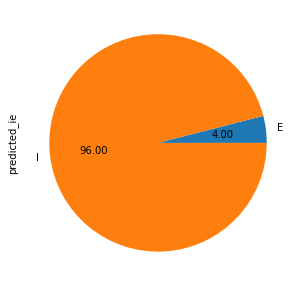

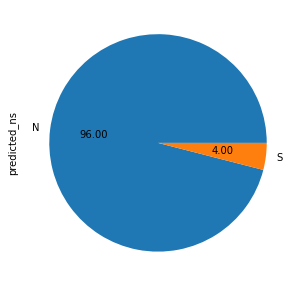

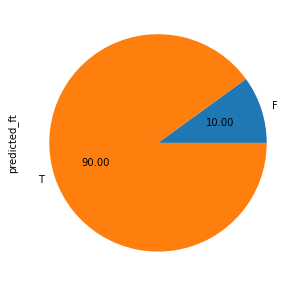

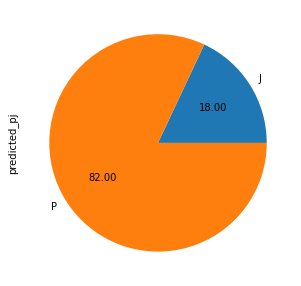

In [ ]:
plt.figure(0)
jacinda_df.groupby('predicted_ie')['predicted_ie'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(1)
jacinda_df.groupby('predicted_ns')['predicted_ns'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(2)
jacinda_df.groupby('predicted_ft')['predicted_ft'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(3)
jacinda_df.groupby('predicted_pj')['predicted_pj'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.show() #show all figures

<Figure size 432x288 with 0 Axes>

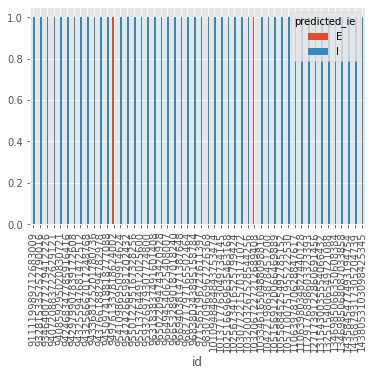

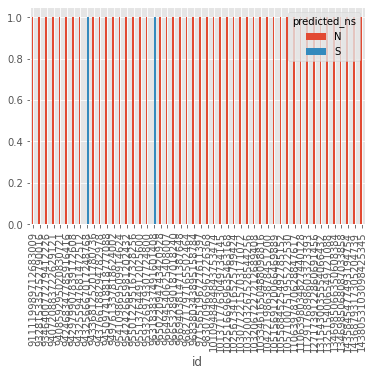

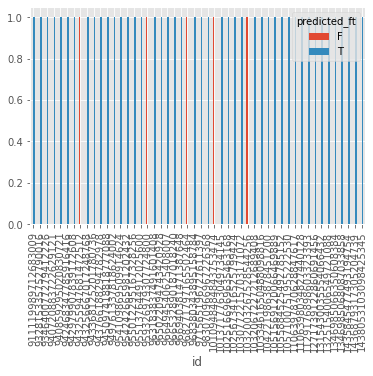

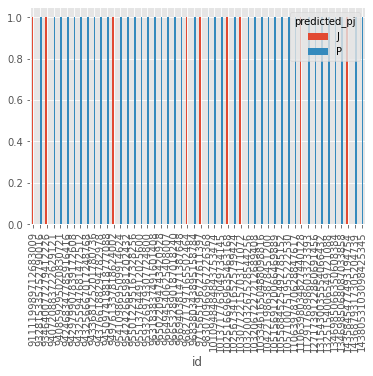

In [ ]:
plt.style.use('ggplot')

plt.figure(0)
jacinda_df.groupby(['id','predicted_ie']).predicted_ie.count().unstack().plot.bar(legend=True)

plt.figure(1)
jacinda_df.groupby(['id','predicted_ns']).predicted_ns.count().unstack().plot.bar(legend=True)

plt.figure(2)
jacinda_df.groupby(['id','predicted_ft']).predicted_ft.count().unstack().plot.bar(legend=True)

plt.figure(3)
jacinda_df.groupby(['id','predicted_pj']).predicted_pj.count().unstack().plot.bar(legend=True)

plt.show() #show all figures

## Prediction for Ursula von der Leyen

In [ ]:
von_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MBTI Project/vonderleyen_tweets - vonderleyen_tweets.csv")
von_df.head()

id  ...                                               text
0  1467901048400449542  ...  Die EU ist der 🌍 größte Spender von #COVID19-I...
1  1467872684038320128  ...  L'UE est le plus important donateur de vaccins...
2  1467870779799142400  ...  The EU is the biggest donor of #COVID19 vaccin...
3  1467830721842667527  ...  Ich gratuliere @karlnehammer zur heutigen Ange...
4  1466832740628770829  ...  Nachhaltiges Wirtschaften und ein bewusster Um...

[5 rows x 5 columns]

In [ ]:
# jac_df = jacinda_df.rename(columns={'text': 'posts'})
# von_df = von_df['text']

In [ ]:
%%time
von_posts = von_df['text']
von_posts = preprocess(von_posts)

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50

CPU times: user 166 ms, sys: 49.2 ms, total: 215 ms
Wall time: 173 ms


In [ ]:
# cv = CountVectorizer(analyzer="word", max_features=1500).fit(jac_posts)
von_X = cv.transform(von_posts)
von_X_tf=  tf.fit_transform(von_X).toarray()

In [ ]:
von_df['predicted_ie'] = ieModel.predict(von_X_tf)
ieModel.predict(von_X_tf)

array(['I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I'],
      dtype=object)

In [ ]:
von_df['predicted_ns'] = nsModel.predict(von_X_tf)
nsModel.predict(von_X_tf)

array(['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
      dtype=object)

In [ ]:
von_df['predicted_ft'] = ftModel.predict(von_X_tf)
ftModel.predict(von_X_tf)

array(['T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'F', 'T', 'T', 'F',
       'T', 'F', 'F', 'F', 'T', 'T', 'F', 'T', 'T', 'T', 'F', 'T', 'T',
       'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T',
       'T', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T'],
      dtype=object)

In [ ]:
von_df['predicted_pj'] = pjModel.predict(von_X_tf)
pjModel.predict(von_X_tf)

array(['P', 'P', 'P', 'P', 'P', 'P', 'J', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'J', 'J', 'J', 'J', 'P',
       'P', 'P', 'P', 'P', 'J', 'P', 'J', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'J', 'P', 'P', 'J', 'P', 'P', 'P'],
      dtype=object)

In [ ]:
von_df['text'] = von_posts
von_df.drop(['created_at','favorite_count', 'retweet_count'], axis=1, inplace= True)
von_df.head(3)

id  ... predicted_pj
0  1467901048400449542  ...            P
1  1467872684038320128  ...            P
2  1467870779799142400  ...            P

[3 rows x 6 columns]

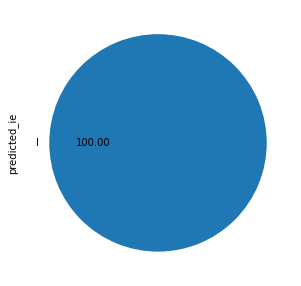

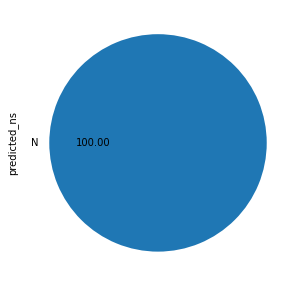

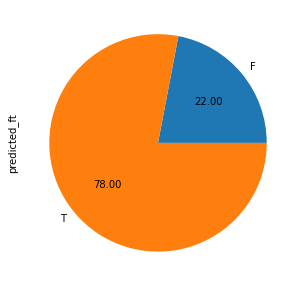

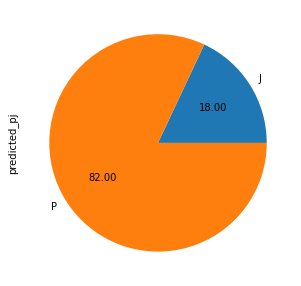

In [ ]:
plt.figure(0)
von_df.groupby('predicted_ie')['predicted_ie'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(1)
von_df.groupby('predicted_ns')['predicted_ns'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(2)
von_df.groupby('predicted_ft')['predicted_ft'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(3)
von_df.groupby('predicted_pj')['predicted_pj'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.show() #show all figures

<Figure size 432x288 with 0 Axes>

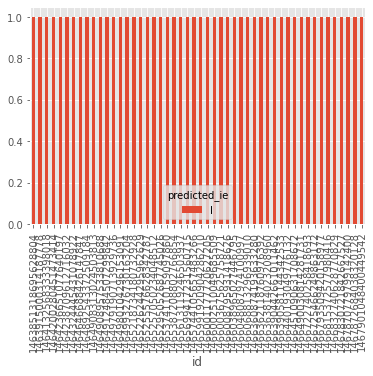

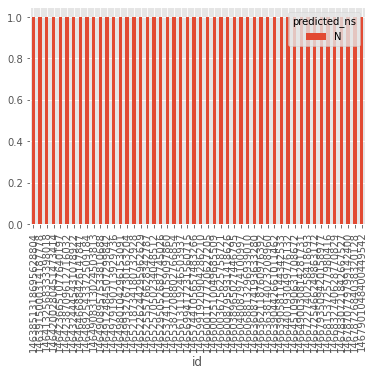

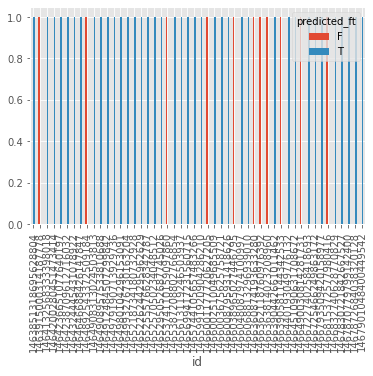

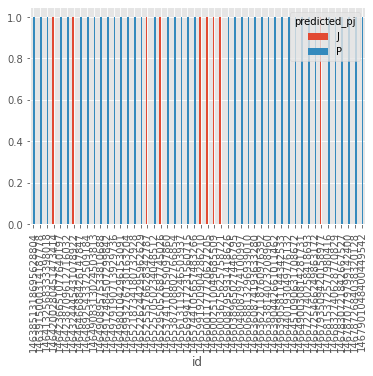

In [ ]:
plt.style.use('ggplot')

plt.figure(0)
von_df.groupby(['id','predicted_ie']).predicted_ie.count().unstack().plot.bar(legend=True)

plt.figure(1)
von_df.groupby(['id','predicted_ns']).predicted_ns.count().unstack().plot.bar(legend=True)

plt.figure(2)
von_df.groupby(['id','predicted_ft']).predicted_ft.count().unstack().plot.bar(legend=True)

plt.figure(3)
von_df.groupby(['id','predicted_pj']).predicted_pj.count().unstack().plot.bar(legend=True)

plt.show() #show all figures

## Prediction for Christine Lagarde

In [ ]:
christine_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MBTI Project/Lagarde_tweets - Lagarde_tweets.csv")
christine_df.head()

id  ...                                               text
0  1467926876400369672  ...  At today’s #Eurogroup meeting we discussed the...
1  1467837507060572167  ...  Very interesting meeting with Belgian Prime Mi...
2  1467779962279186434  ...  For almost 20 years now, euro banknotes have b...
3  1467423359940050945  ...  Ngozi Okonjo-Iweala, Director-General of the @...
4  1467085087531544582  ...  Come ho detto la scorsa settimana da @fabfazio...

[5 rows x 5 columns]

In [ ]:
# jac_df = jacinda_df.rename(columns={'text': 'posts'})
chris_df = christine_df['text']

In [ ]:
%%time
chris_posts = chris_df
chris_posts = preprocess(chris_posts)

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50

CPU times: user 152 ms, sys: 35.9 ms, total: 188 ms
Wall time: 150 ms


In [ ]:
# cv = CountVectorizer(analyzer="word", max_features=1500).fit(jac_posts)
chris_X = cv.transform(chris_posts)
chris_X_tf=  tf.fit_transform(chris_X).toarray()

In [ ]:
christine_df['predicted_ie'] = ieModel.predict(chris_X_tf)
ieModel.predict(chris_X_tf)

array(['I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I'],
      dtype=object)

In [ ]:
christine_df['predicted_ns'] = nsModel.predict(chris_X_tf)
nsModel.predict(chris_X_tf)

array(['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
      dtype=object)

In [ ]:
christine_df['predicted_ft'] = ftModel.predict(chris_X_tf)
ftModel.predict(chris_X_tf)

array(['T', 'F', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T',
       'F', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'F', 'T',
       'F', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'F', 'T', 'T',
       'T', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T'],
      dtype=object)

In [ ]:
christine_df['predicted_pj'] = pjModel.predict(chris_X_tf)
pjModel.predict(chris_X_tf)

array(['P', 'P', 'J', 'P', 'P', 'P', 'P', 'P', 'J', 'P', 'J', 'J', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'J', 'P', 'P',
       'P', 'J', 'P', 'P', 'J', 'P', 'J', 'P', 'P', 'P', 'P', 'J', 'P',
       'P', 'P', 'P', 'P', 'P', 'J', 'J', 'P', 'J', 'P', 'J'],
      dtype=object)

In [ ]:
christine_df['text'] = chris_posts
christine_df.drop(['created_at','favorite_count', 'retweet_count'], axis=1, inplace= True)
christine_df.head(3)

id  ... predicted_pj
0  1467926876400369672  ...            P
1  1467837507060572167  ...            P
2  1467779962279186434  ...            J

[3 rows x 6 columns]

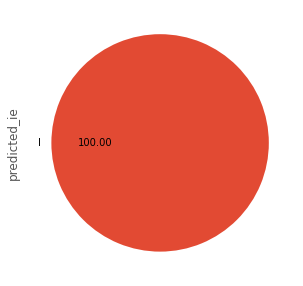

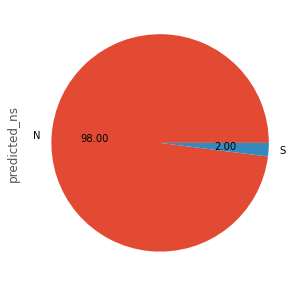

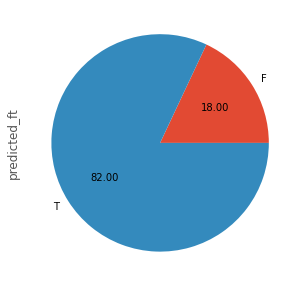

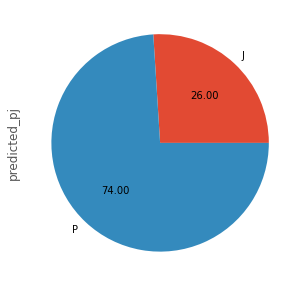

In [ ]:
plt.figure(0)
christine_df.groupby('predicted_ie')['predicted_ie'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(1)
christine_df.groupby('predicted_ns')['predicted_ns'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(2)
christine_df.groupby('predicted_ft')['predicted_ft'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(3)
christine_df.groupby('predicted_pj')['predicted_pj'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.show() #show all figures

<Figure size 432x288 with 0 Axes>

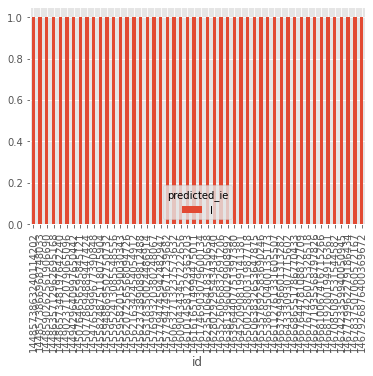

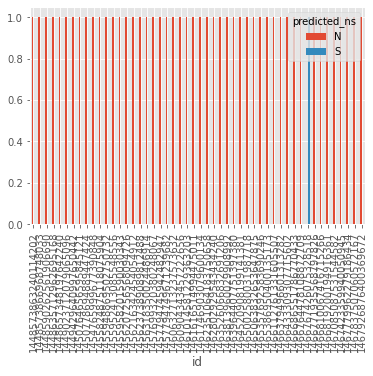

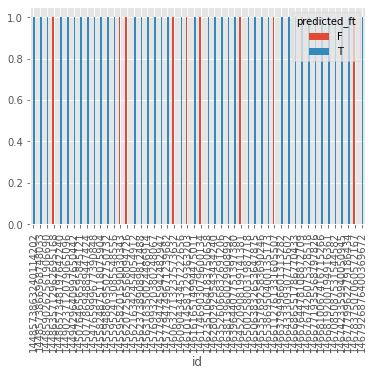

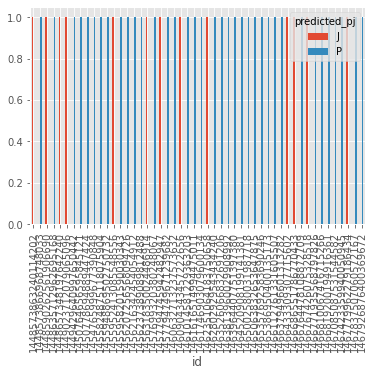

In [ ]:
plt.style.use('ggplot')

plt.figure(0)
christine_df.groupby(['id','predicted_ie']).predicted_ie.count().unstack().plot.bar(legend=True)

plt.figure(1)
christine_df.groupby(['id','predicted_ns']).predicted_ns.count().unstack().plot.bar(legend=True)

plt.figure(2)
christine_df.groupby(['id','predicted_ft']).predicted_ft.count().unstack().plot.bar(legend=True)

plt.figure(3)
christine_df.groupby(['id','predicted_pj']).predicted_pj.count().unstack().plot.bar(legend=True)

plt.show() #show all figures

## Prediction for Nancy Pelosi

In [ ]:
nancy_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MBTI Project/SpeakerPelosi_tweets - SpeakerPelosi_tweets.csv")
nancy_df.head()

id  ...                                               text
0  1467953864867467268  ...  Senator Bob Dole was an extraordinary patriot....
1  1467945515904086016  ...  The Congress has and will continue our long bi...
2  1467945514809372681  ...  Allowing a country notorious for its appalling...
3  1467945513626578947  ...  While we must support and celebrate our athlet...
4  1467945512326373379  ...  As I noted when I called for a diplomatic boyc...

[5 rows x 5 columns]

In [ ]:
# jac_df = jacinda_df.rename(columns={'text': 'posts'})
nan_df = nancy_df['text']

In [ ]:
%%time
nan_posts = nan_df
nan_posts = preprocess(nan_posts)

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50

CPU times: user 156 ms, sys: 1.36 ms, total: 157 ms
Wall time: 210 ms


In [ ]:
# cv = CountVectorizer(analyzer="word", max_features=1500).fit(jac_posts)
nan_X = cv.transform(nan_posts)
nan_X_tf=  tf.fit_transform(nan_X).toarray()

In [ ]:
nancy_df['predicted_ie'] = ieModel.predict(nan_X_tf)
ieModel.predict(nan_X_tf)

array(['I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I'],
      dtype=object)

In [ ]:
nancy_df['predicted_ns'] = nsModel.predict(nan_X_tf)
nsModel.predict(nan_X_tf)

array(['N', 'N', 'N', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'S', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'S', 'N',
       'N', 'N', 'S', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'N'],
      dtype=object)

In [ ]:
nancy_df['predicted_ft'] = ftModel.predict(nan_X_tf)
ftModel.predict(nan_X_tf)

array(['F', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'F', 'T', 'F', 'T',
       'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T',
       'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'F', 'T', 'T', 'T', 'T',
       'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T'],
      dtype=object)

In [ ]:
nancy_df['predicted_pj'] = pjModel.predict(nan_X_tf)
pjModel.predict(nan_X_tf)

array(['P', 'P', 'P', 'J', 'P', 'P', 'P', 'P', 'P', 'J', 'P', 'J', 'J',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'J', 'J', 'P', 'P', 'P', 'P',
       'J', 'J', 'J', 'J', 'P', 'J', 'P', 'P', 'P', 'P', 'P'],
      dtype=object)

In [ ]:
nancy_df['text'] = nan_posts
nancy_df.drop(['created_at','favorite_count', 'retweet_count'], axis=1, inplace= True)
nancy_df.head(3)

id  ... predicted_pj
0  1467953864867467268  ...            P
1  1467945515904086016  ...            P
2  1467945514809372681  ...            P

[3 rows x 6 columns]

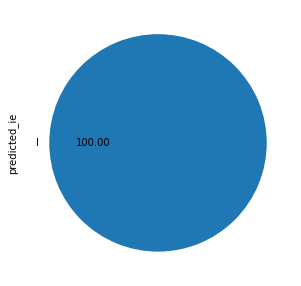

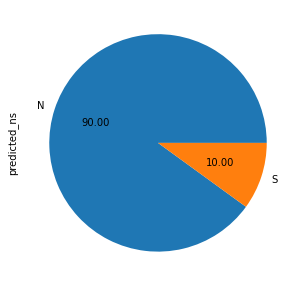

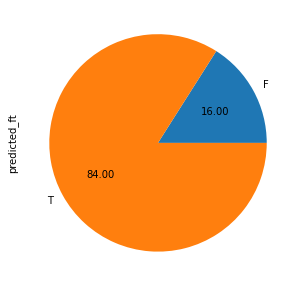

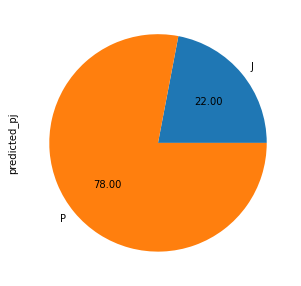

In [ ]:
plt.figure(0)
nancy_df.groupby('predicted_ie')['predicted_ie'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(1)
nancy_df.groupby('predicted_ns')['predicted_ns'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(2)
nancy_df.groupby('predicted_ft')['predicted_ft'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(3)
nancy_df.groupby('predicted_pj')['predicted_pj'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.show() #show all figures

<Figure size 432x288 with 0 Axes>

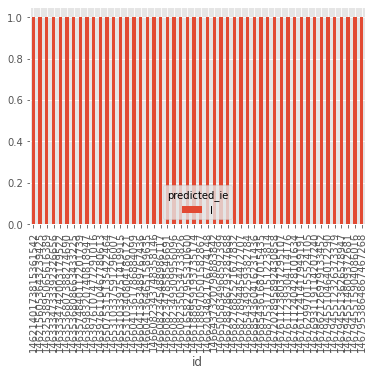

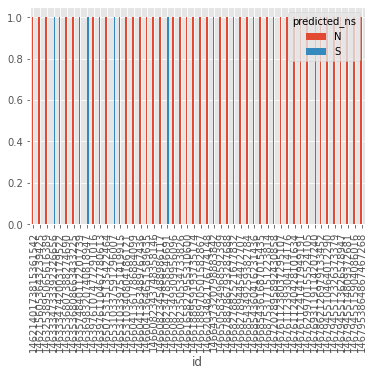

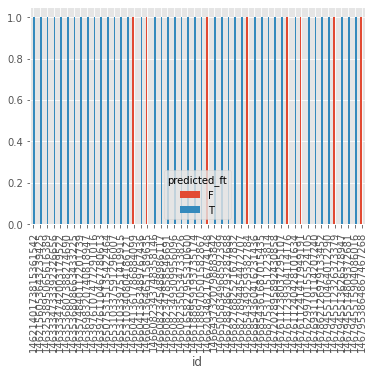

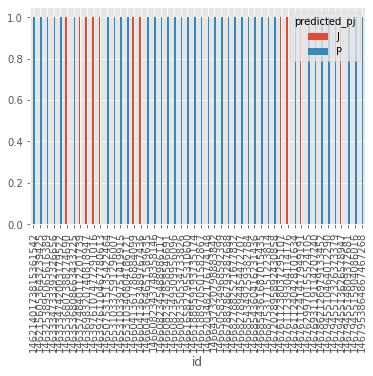

In [ ]:
plt.style.use('ggplot')

plt.figure(0)
nancy_df.groupby(['id','predicted_ie']).predicted_ie.count().unstack().plot.bar(legend=True)

plt.figure(1)
nancy_df.groupby(['id','predicted_ns']).predicted_ns.count().unstack().plot.bar(legend=True)

plt.figure(2)
nancy_df.groupby(['id','predicted_ft']).predicted_ft.count().unstack().plot.bar(legend=True)

plt.figure(3)
nancy_df.groupby(['id','predicted_pj']).predicted_pj.count().unstack().plot.bar(legend=True)

plt.show() #show all figures

## Prediction for Kamala Harris

In [ ]:
kam_df = pd.read_csv("/content/drive/MyDrive/KremlinRussia_E_tweets.csv")
kam_df.head()

id  ...                                               text
0  1471079334454730753  ...  Meeting with President of China Xi Jinping: de...
1  1470823107074174992  ...  Vladimir Putin held a meeting with Government ...
2  1470820201704923145  ...  Telephone conversation with President of Franc...
3  1470788427352264706  ...  Telephone conversation with President of Finla...
4  1470676984707571717  ...  On December 16, Vladimir Putin will hold talks...

[5 rows x 5 columns]

In [ ]:
%%time
kam_posts = kam_df['text']
kam_posts = preprocess(kam_posts)

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50

CPU times: user 82.7 ms, sys: 6.71 ms, total: 89.4 ms
Wall time: 102 ms


In [ ]:
# cv = CountVectorizer(analyzer="word", max_features=1500).fit(jac_posts)
kam_X = cv.transform(kam_posts)
kam_X_tf=  tf.fit_transform(kam_X).toarray()

In [ ]:
predicted_ie = ieModel.predict(kam_X_tf)
ieModel.predict(kam_X_tf)

array(['I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I'],
      dtype=object)

In [ ]:
predicted_ns = nsModel.predict(kam_X_tf)
nsModel.predict(kam_X_tf)

array(['N', 'N', 'N', 'N', 'S', 'N', 'N', 'S', 'S', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'S',
       'N', 'N', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'S', 'N'],
      dtype=object)

In [ ]:
predicted_ft = ftModel.predict(kam_X_tf)
ftModel.predict(kam_X_tf)

array(['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T',
       'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T',
       'F', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T',
       'F', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T'],
      dtype=object)

In [ ]:
predicted_pj = pjModel.predict(kam_X_tf)
pjModel.predict(kam_X_tf)

array(['P', 'P', 'J', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'J', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'J', 'P', 'J', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'J', 'P', 'P', 'P', 'P', 'P'],
      dtype=object)

In [ ]:
kam_df['text'] = kam_posts
kam_df['predicted_ie'] = predicted_ie
kam_df['predicted_ns'] = predicted_ns
kam_df['predicted_ft'] = predicted_ft
kam_df['predicted_pj'] = predicted_pj
kam_df.drop(['created_at','favorite_count', 'retweet_count'], axis=1, inplace= True)
kam_df.head(3)

id  ... predicted_pj
0  1471079334454730753  ...            P
1  1470823107074174992  ...            P
2  1470820201704923145  ...            J

[3 rows x 6 columns]

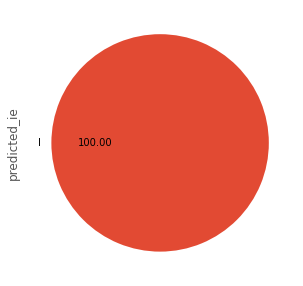

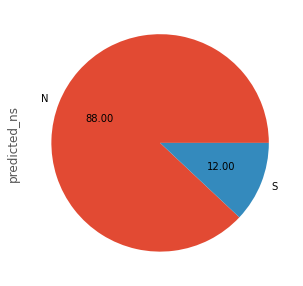

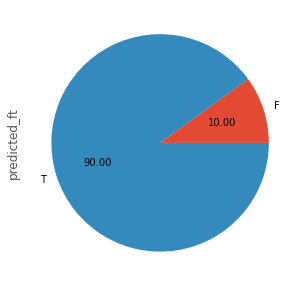

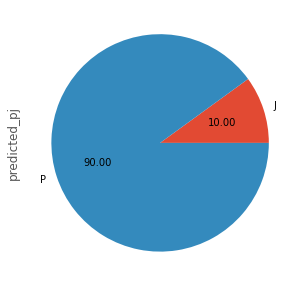

In [ ]:
plt.figure(0)
kam_df.groupby('predicted_ie')['predicted_ie'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(1)
kam_df.groupby('predicted_ns')['predicted_ns'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(2)
kam_df.groupby('predicted_ft')['predicted_ft'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(3)
kam_df.groupby('predicted_pj')['predicted_pj'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.show() #show all figures

<Figure size 432x288 with 0 Axes>

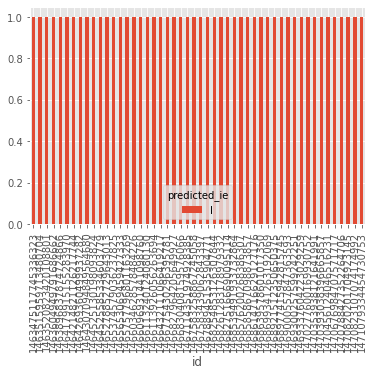

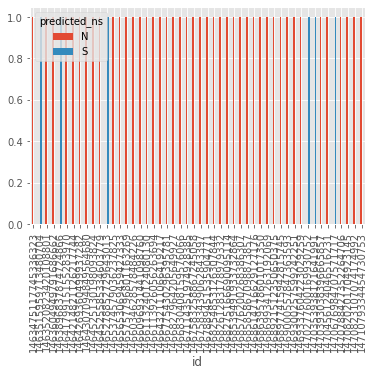

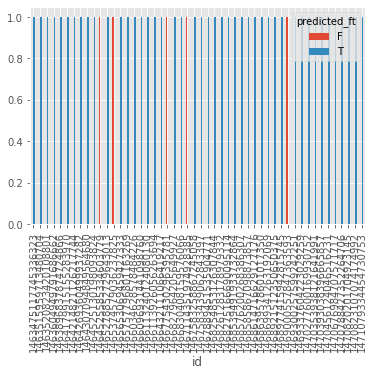

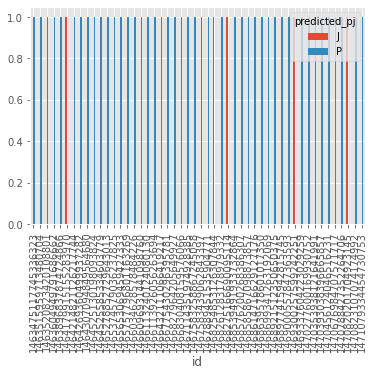

In [ ]:
plt.style.use('ggplot')

plt.figure(0)
kam_df.groupby(['id','predicted_ie']).predicted_ie.count().unstack().plot.bar(legend=True)

plt.figure(1)
kam_df.groupby(['id','predicted_ns']).predicted_ns.count().unstack().plot.bar(legend=True)

plt.figure(2)
kam_df.groupby(['id','predicted_ft']).predicted_ft.count().unstack().plot.bar(legend=True)

plt.figure(3)
kam_df.groupby(['id','predicted_pj']).predicted_pj.count().unstack().plot.bar(legend=True)

plt.show() #show all figures

## Prediction for Pope Francis

In [ ]:
pope_df = pd.read_csv("/content/drive/MyDrive/Pontifex_tweets.csv")
pope_df.head()

id  ...                                               text
0  1471109245320011777  ...  As we draw near to #Christmas, let us learn fr...
1  1470732804828717066  ...  #Advent invites us to prepare ourselves for Ch...
2  1470370419806978050  ...  Life is a time for making decisive, eternal ch...
3  1470038228073959441  ...  Let us #PrayTogether for dear Ukraine, so that...
4  1469992934921494534  ...  "What should we do?" (Lk. 3:10). With this que...

[5 rows x 5 columns]

In [ ]:

pop_df = pope_df['text']

In [ ]:
%%time
pop_posts = pop_df
pop_posts = preprocess(pop_posts)

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50

CPU times: user 153 ms, sys: 50.9 ms, total: 204 ms
Wall time: 167 ms


In [ ]:
# cv = CountVectorizer(analyzer="word", max_features=1500).fit(jac_posts)
pop_X = cv.transform(pop_posts)
pop_X_tf=  tf.fit_transform(pop_X).toarray()

In [ ]:
ieModel = model_linear_svc.fit(xIETrain, yIE)

In [ ]:
predicted_ie = ieModel.predict(pop_X_tf)
ieModel.predict(pop_X_tf)

array(['I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I'],
      dtype=object)

In [ ]:
nsModel =  model_linear_svc.fit(xNSTrain, yNS)

In [ ]:
predicted_ns = nsModel.predict(pop_X_tf)
nsModel.predict(pop_X_tf)

array(['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
      dtype=object)

In [ ]:
ftModel =  model_linear_svc.fit(xFTTrain, yFT)

In [ ]:
predicted_ft = ftModel.predict(pop_X_tf)
ftModel.predict(pop_X_tf)

array(['T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'F',
       'F', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'F',
       'T', 'F', 'T', 'F', 'T', 'T', 'F', 'T', 'F', 'T', 'T', 'T', 'T',
       'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'F'],
      dtype=object)

In [ ]:
pjModel =  model_linear_svc.fit(xPJTrain, yPJ)

In [ ]:
predicted_pj = pjModel.predict(pop_X_tf)
pjModel.predict(pop_X_tf)

array(['P', 'J', 'J', 'J', 'J', 'P', 'P', 'P', 'J', 'J', 'P', 'J', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'J', 'P', 'P', 'P', 'P',
       'P', 'J', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'J', 'P',
       'P', 'P', 'P', 'J', 'P', 'P', 'P', 'P', 'P', 'J', 'J'],
      dtype=object)

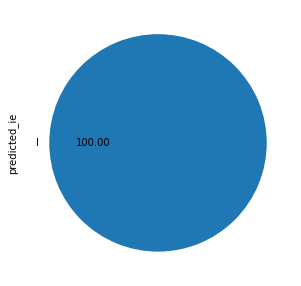

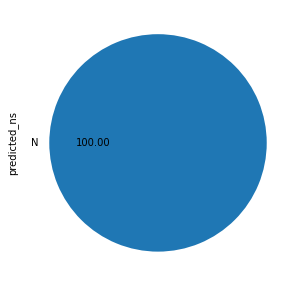

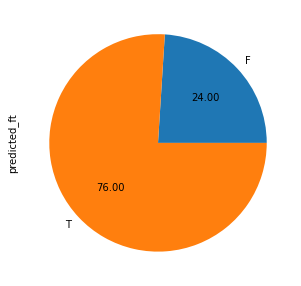

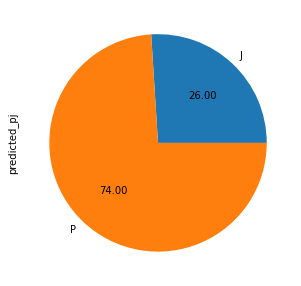

In [ ]:
plt.figure(0)
pope_df.groupby('predicted_ie')['predicted_ie'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(1)
pope_df.groupby('predicted_ns')['predicted_ns'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(2)
pope_df.groupby('predicted_ft')['predicted_ft'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(3)
pope_df.groupby('predicted_pj')['predicted_pj'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.show() #show all figures

<Figure size 432x288 with 0 Axes>

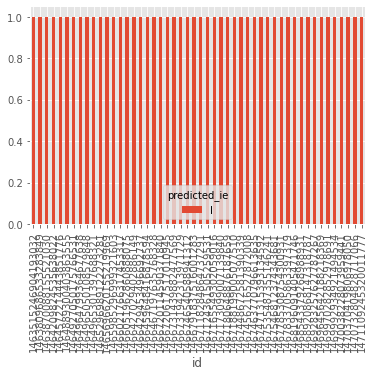

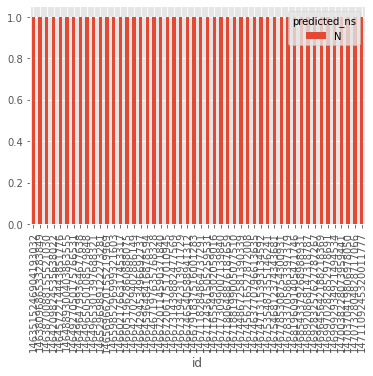

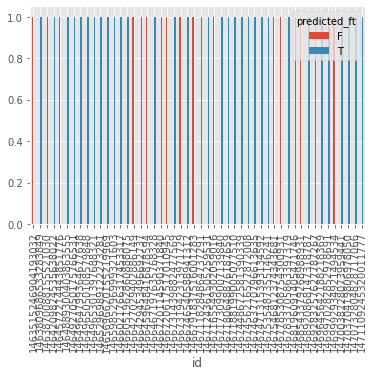

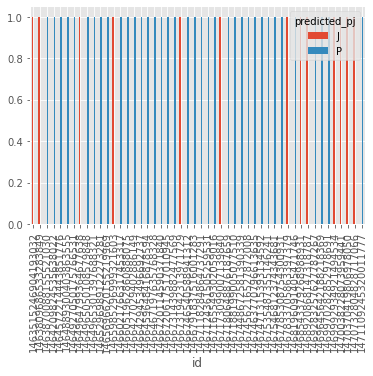

In [ ]:
plt.style.use('ggplot')

plt.figure(0)
pope_df.groupby(['id','predicted_ie']).predicted_ie.count().unstack().plot.bar(legend=True)

plt.figure(1)
pope_df.groupby(['id','predicted_ns']).predicted_ns.count().unstack().plot.bar(legend=True)

plt.figure(2)
pope_df.groupby(['id','predicted_ft']).predicted_ft.count().unstack().plot.bar(legend=True)

plt.figure(3)
pope_df.groupby(['id','predicted_pj']).predicted_pj.count().unstack().plot.bar(legend=True)

plt.show() #show all figures

## Prediction for Rupert Murdoch

In [ ]:
rupe_df = pd.read_csv("/content/drive/MyDrive/rupertmadoch_tweets.csv")
rupe_df.head()

id  ...                                               text
0  1471109245320011777  ...  As we draw near to #Christmas, let us learn fr...
1  1470732804828717066  ...  #Advent invites us to prepare ourselves for Ch...
2  1470370419806978050  ...  Life is a time for making decisive, eternal ch...
3  1470038228073959441  ...  Let us #PrayTogether for dear Ukraine, so that...
4  1469992934921494534  ...  "What should we do?" (Lk. 3:10). With this que...

[5 rows x 5 columns]

In [ ]:
%%time
rupe_posts = rupe_df['text']
rupe_posts = preprocess(rupe_posts)

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50

CPU times: user 170 ms, sys: 34.3 ms, total: 204 ms
Wall time: 175 ms


In [ ]:
# cv = CountVectorizer(analyzer="word", max_features=1500).fit(jac_posts)
rupe_X = cv.transform(rupe_posts)
rupe_X_tf=  tf.fit_transform(rupe_X).toarray()

In [ ]:
ieModel = model_linear_svc.fit(xIETrain, yIE)

In [ ]:
predicted_ie = ieModel.predict(rupe_X_tf)
ieModel.predict(rupe_X_tf)

array(['I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I'],
      dtype=object)

In [ ]:
nsModel =  model_linear_svc.fit(xNSTrain, yNS)

In [ ]:
predicted_ns = nsModel.predict(rupe_X_tf)
nsModel.predict(rupe_X_tf)

array(['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
      dtype=object)

In [ ]:
ftModel =  model_linear_svc.fit(xFTTrain, yFT)

In [ ]:
predicted_ft = ftModel.predict(pop_X_tf)
ftModel.predict(pop_X_tf)

array(['T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'F',
       'F', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'F',
       'T', 'F', 'T', 'F', 'T', 'T', 'F', 'T', 'F', 'T', 'T', 'T', 'T',
       'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'F'],
      dtype=object)

In [ ]:
pjModel =  model_linear_svc.fit(xPJTrain, yPJ)

In [ ]:
predicted_pj = pjModel.predict(rupe_X_tf)
pjModel.predict(rupe_X_tf)

array(['P', 'J', 'J', 'J', 'J', 'P', 'P', 'P', 'J', 'J', 'P', 'J', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'J', 'P', 'P', 'P', 'P',
       'P', 'J', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'J', 'P',
       'P', 'P', 'P', 'J', 'P', 'P', 'P', 'P', 'P', 'J', 'J'],
      dtype=object)

In [ ]:
rupe_df['text'] = rupe_posts
rupe_df['predicted_ie'] = predicted_ie
rupe_df['predicted_ns'] = predicted_ns
rupe_df['predicted_ft'] = predicted_ft
rupe_df['predicted_pj'] = predicted_pj
rupe_df.drop(['created_at','favorite_count', 'retweet_count'], axis=1, inplace= True)
rupe_df.head(3)

id  ... predicted_pj
0  1471109245320011777  ...            P
1  1470732804828717066  ...            J
2  1470370419806978050  ...            J

[3 rows x 6 columns]

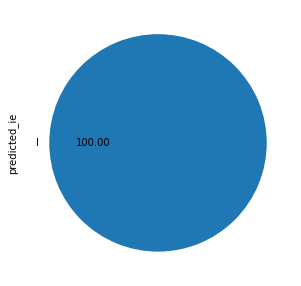

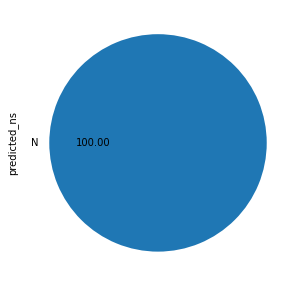

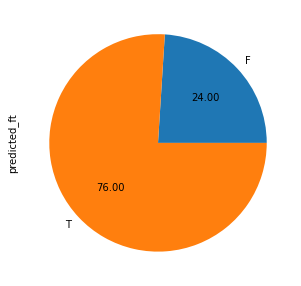

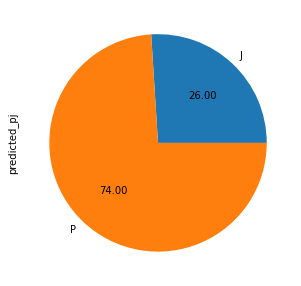

In [ ]:
plt.figure(0)
rupe_df.groupby('predicted_ie')['predicted_ie'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(1)
rupe_df.groupby('predicted_ns')['predicted_ns'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(2)
rupe_df.groupby('predicted_ft')['predicted_ft'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(3)
rupe_df.groupby('predicted_pj')['predicted_pj'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.show() #show all figures

<Figure size 432x288 with 0 Axes>

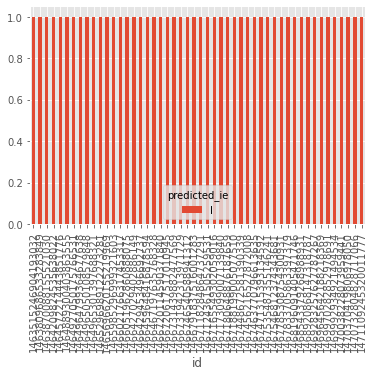

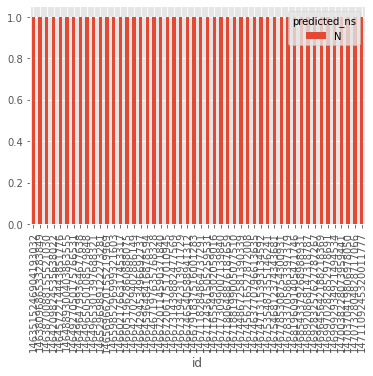

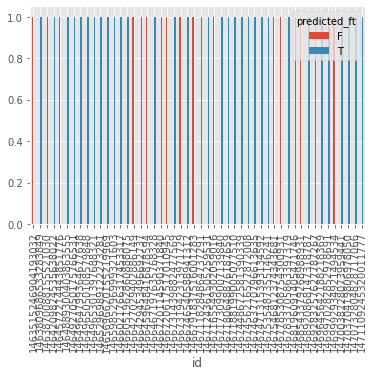

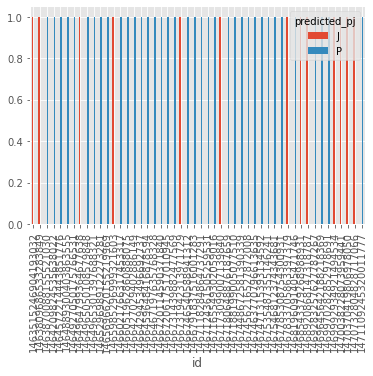

In [ ]:
plt.style.use('ggplot')

plt.figure(0)
rupe_df.groupby(['id','predicted_ie']).predicted_ie.count().unstack().plot.bar(legend=True)

plt.figure(1)
rupe_df.groupby(['id','predicted_ns']).predicted_ns.count().unstack().plot.bar(legend=True)

plt.figure(2)
rupe_df.groupby(['id','predicted_ft']).predicted_ft.count().unstack().plot.bar(legend=True)

plt.figure(3)
rupe_df.groupby(['id','predicted_pj']).predicted_pj.count().unstack().plot.bar(legend=True)

plt.show() #show all figures

## Prediction for Vladimir Putin

In [ ]:
put_df = pd.read_csv("/content/drive/MyDrive/KamalaHarris_tweets.csv")
put_df.head()

id  ...                                               text
0  1470885369017159683  ...  By developing and deploying chargers for elect...
1  1470831049588498433  ...  Yesterday, I headed to Prince George’s County,...
2  1470768291648000013  ...  We know the path to controlling COVID-19 and l...
3  1470571241400590337  ...  Seventeen Nobel Prize-winning economists wrote...
4  1470498512517443591  ...  Our Build Back Better Act invests in maternal ...

[5 rows x 5 columns]

In [ ]:
%%time
put_posts = put_df['text']
put_posts = preprocess(put_posts)

1/51
2/51
3/51
4/51
5/51
6/51
7/51
8/51
9/51
10/51
11/51
12/51
13/51
14/51
15/51
16/51
17/51
18/51
19/51
20/51
21/51
22/51
23/51
24/51
25/51
26/51
27/51
28/51
29/51
30/51
31/51
32/51
33/51
34/51
35/51
36/51
37/51
38/51
39/51
40/51
41/51
42/51
43/51
44/51
45/51
46/51
47/51
48/51
49/51
50/51
51/51

CPU times: user 189 ms, sys: 46.3 ms, total: 235 ms
Wall time: 182 ms


In [ ]:
# cv = CountVectorizer(analyzer="word", max_features=1500).fit(jac_posts)
put_X = cv.transform(put_posts)
put_X_tf=  tf.fit_transform(put_X).toarray()

In [ ]:
predicted_ie = ieModel.predict(put_X_tf)
ieModel.predict(put_X_tf)

array(['I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I'],
      dtype=object)

In [ ]:
predicted_ns = nsModel.predict(put_X_tf)
nsModel.predict(put_X_tf)

array(['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'N', 'N', 'N',
       'S', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'S', 'N', 'S', 'N', 'N'],
      dtype=object)

In [ ]:
predicted_ft = ftModel.predict(put_X_tf)
ftModel.predict(put_X_tf)

array(['T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'F', 'T', 'F',
       'F', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T',
       'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T',
       'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T'],
      dtype=object)

In [ ]:
predicted_pj = pjModel.predict(put_X_tf)
pjModel.predict(put_X_tf)

array(['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'J', 'J', 'P',
       'P', 'J', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'J', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'J'],
      dtype=object)

In [ ]:
put_df['text'] = put_posts
put_df['predicted_ie'] = predicted_ie
put_df['predicted_ns'] = predicted_ns
put_df['predicted_ft'] = predicted_ft
put_df['predicted_pj'] = predicted_pj
# put_df.drop(['created_at','favorite_count', 'retweet_count'], axis=1, inplace= True)
put_df.head(3)

id  ... predicted_pj
0  1470885369017159683  ...            P
1  1470831049588498433  ...            P
2  1470768291648000013  ...            P

[3 rows x 6 columns]

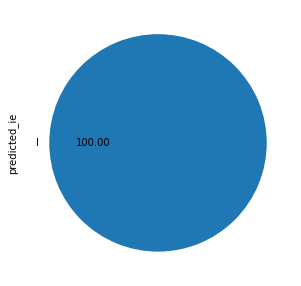

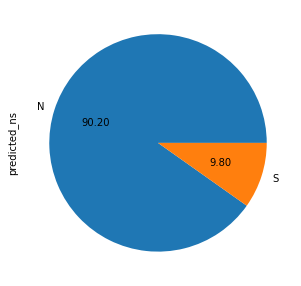

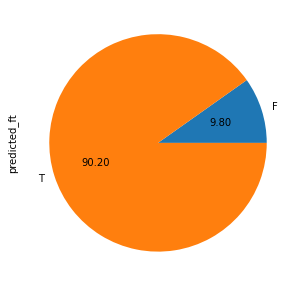

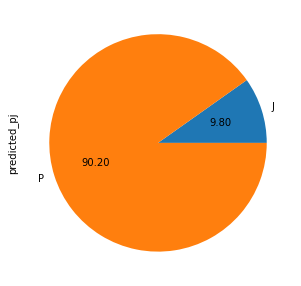

In [ ]:
plt.figure(0)
put_df.groupby('predicted_ie')['predicted_ie'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(1)
put_df.groupby('predicted_ns')['predicted_ns'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(2)
put_df.groupby('predicted_ft')['predicted_ft'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(3)
put_df.groupby('predicted_pj')['predicted_pj'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.show() #show all figures

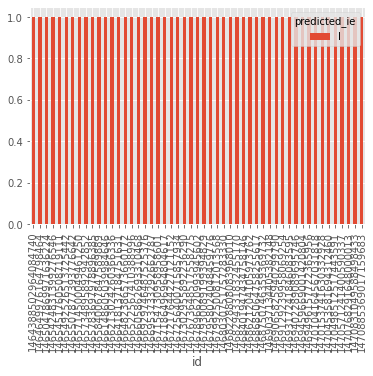

In [ ]:
plt.style.use('ggplot')

put_df.groupby(['id', 'predicted_ie'])\
      .predicted_ie.count().unstack().plot.bar(legend=True)

plt.show()

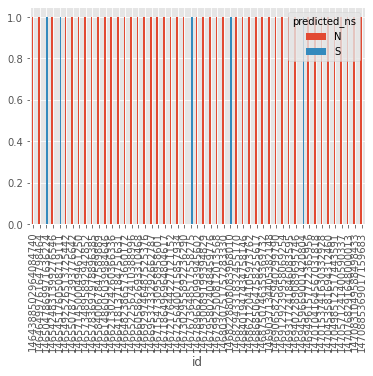

In [ ]:
plt.style.use('ggplot')

put_df.groupby(['id', 'predicted_ns'])\
      .predicted_ns.count().unstack().plot.bar(legend=True)

plt.show()

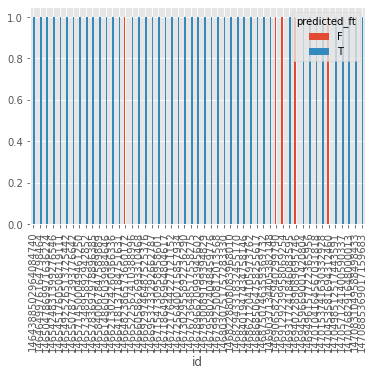

In [ ]:
plt.style.use('ggplot')

put_df.groupby(['id', 'predicted_ft'])\
      .predicted_ft.count().unstack().plot.bar(legend=True)

plt.show()

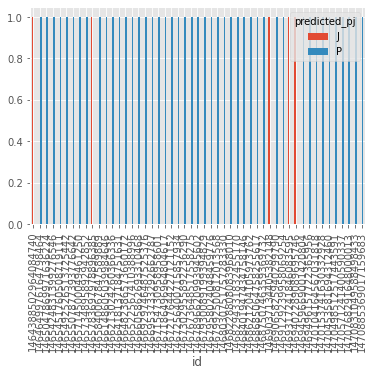

In [ ]:
plt.style.use('ggplot')

put_df.groupby(['id', 'predicted_pj'])\
      .predicted_pj.count().unstack().plot.bar(legend=True)

plt.show()

## Prediction for Jeff Bezos

In [ ]:
jeff_df = pd.read_csv("/content/drive/MyDrive/ai project/JeffBezos_tweets.csv")
jeff_df.head()

id  ...                                               text
0  1469849247042334721  ...  (2/2) All of Edwardsville should know that the...
1  1469849245624647681  ...  The news from Edwardsville is tragic. We’re he...
2  1469320158996951043  ...  Loved being with @MichaelStrahan on Thursday N...
3  1469107355530919938  ...  Congrats again, DJ. No one more deserving than...
4  1467937061319495681  ...  Today the Washington Post and the world lost a...

[5 rows x 5 columns]

In [ ]:
# jac_df = jacinda_df.rename(columns={'text': 'posts'})
jeff_df = jeff_df['text']

In [ ]:
%%time
jeff_posts = jeff_df
jeff_posts = preprocess(jeff_posts)

1/52
2/52
3/52
4/52
5/52
6/52
7/52
8/52
9/52
10/52
11/52
12/52
13/52
14/52
15/52
16/52
17/52
18/52
19/52
20/52
21/52
22/52
23/52
24/52
25/52
26/52
27/52
28/52
29/52
30/52
31/52
32/52
33/52
34/52
35/52
36/52
37/52
38/52
39/52
40/52
41/52
42/52
43/52
44/52
45/52
46/52
47/52
48/52
49/52
50/52
51/52
52/52

CPU times: user 166 ms, sys: 37.3 ms, total: 203 ms
Wall time: 163 ms


In [ ]:
# cv = CountVectorizer(analyzer="word", max_features=1500).fit(jac_posts)
jeff_X = cv.transform(jeff_posts)
jeff_X_tf=  tf.fit_transform(jeff_X).toarray()

In [ ]:
predicted_ie = ieModel.predict(jeff_X_tf)
ieModel.predict(jeff_X_tf)

array(['I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'E', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I'],
      dtype=object)

In [ ]:
predicted_ns = nsModel.predict(jeff_X_tf)
nsModel.predict(jeff_X_tf)

array(['N', 'N', 'N', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'N', 'S', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
      dtype=object)

In [ ]:
predicted_ft = ftModel.predict(jeff_X_tf)
ftModel.predict(jeff_X_tf)

array(['T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T',
       'T', 'T', 'F', 'F', 'F', 'F', 'F', 'T', 'T', 'T', 'F', 'T', 'T',
       'T', 'T', 'T', 'T', 'T', 'F', 'T', 'F', 'T', 'T', 'F', 'T', 'F',
       'F', 'T', 'F', 'F', 'F', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T'],
      dtype=object)

In [ ]:
predicted_pj = pjModel.predict(jeff_X_tf)
pjModel.predict(jeff_X_tf)

array(['J', 'P', 'P', 'P', 'P', 'P', 'J', 'P', 'P', 'P', 'P', 'J', 'P',
       'J', 'P', 'J', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'J', 'P', 'P', 'P', 'P', 'P', 'J', 'P'],
      dtype=object)

In [ ]:
jeff_df['text'] = jeff_posts
jeff_df['predicted_ie'] = predicted_ie
jeff_df['predicted_ns'] = predicted_ns
jeff_df['predicted_ft'] = predicted_ft
jeff_df['predicted_pj'] = predicted_pj
jeff_df.drop(['created_at','favorite_count', 'retweet_count'], axis=1, inplace= True)
jeff_df.head(3)

id  ... predicted_pj
0  1469849247042334721  ...            J
1  1469849245624647681  ...            P
2  1469320158996951043  ...            P

[3 rows x 6 columns]

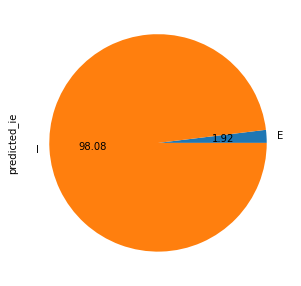

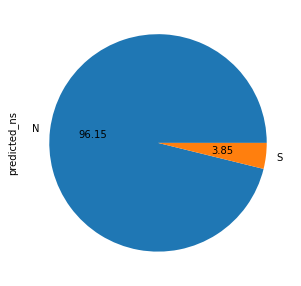

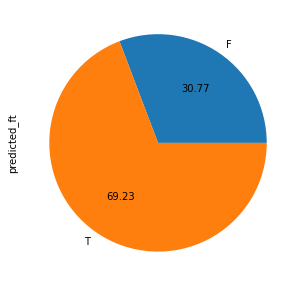

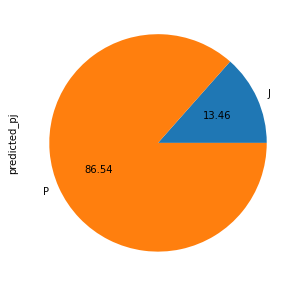

In [ ]:
plt.figure(0)
jeff_df.groupby('predicted_ie')['predicted_ie'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(1)
jeff_df.groupby('predicted_ns')['predicted_ns'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(2)
jeff_df.groupby('predicted_ft')['predicted_ft'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(3)
jeff_df.groupby('predicted_pj')['predicted_pj'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.show() #show all figures

<Figure size 432x288 with 0 Axes>

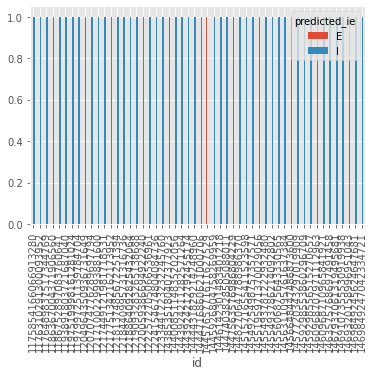

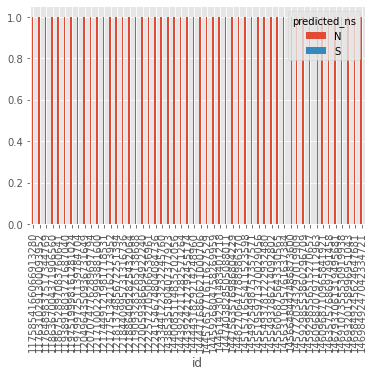

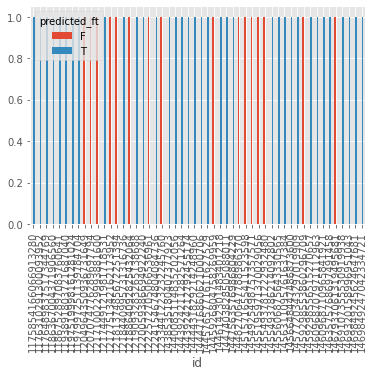

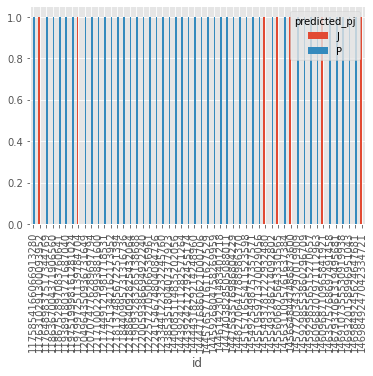

In [ ]:
plt.style.use('ggplot')

plt.figure(0)
jeff_df.groupby(['id','predicted_ie']).predicted_ie.count().unstack().plot.bar(legend=True)

plt.figure(1)
jeff_df.groupby(['id','predicted_ns']).predicted_ns.count().unstack().plot.bar(legend=True)

plt.figure(2)
jeff_df.groupby(['id','predicted_ft']).predicted_ft.count().unstack().plot.bar(legend=True)

plt.figure(3)
jeff_df.groupby(['id','predicted_pj']).predicted_pj.count().unstack().plot.bar(legend=True)

plt.show() #show all figures

## Prediction for Lloyd Blankfein

In [ ]:
lloyd_df = pd.read_csv("/content/drive/MyDrive/ai project/lloydblankfein_tweets.csv")
lloyd_df.head()

id  ...                                               text
0  1461788977321684997  ...  When rates normalize, the risk of a mkt/econom...
1  1457930409166114818  ...  Debatable if Biden was elected to be FDR, but ...
2  1457063512501522436  ...  I get the neg sentiment towards pharma, but re...
3  1457024737490653188  ...                              Progressives blinked.
4  1316492116374233088  ...  Stimulus bill: Dems want $2.2trio and Reps off...

[5 rows x 5 columns]

In [ ]:
%%time
lloyd_posts = lloyd_df['text']
lloyd_posts = preprocess(lloyd_posts)

1/51
2/51
3/51
4/51
5/51
6/51
7/51
8/51
9/51
10/51
11/51
12/51
13/51
14/51
15/51
16/51
17/51
18/51
19/51
20/51
21/51
22/51
23/51
24/51
25/51
26/51
27/51
28/51
29/51
30/51
31/51
32/51
33/51
34/51
35/51
36/51
37/51
38/51
39/51
40/51
41/51
42/51
43/51
44/51
45/51
46/51
47/51
48/51
49/51
50/51
51/51

CPU times: user 162 ms, sys: 16.9 ms, total: 179 ms
Wall time: 282 ms


In [ ]:
# cv = CountVectorizer(analyzer="word", max_features=1500).fit(jac_posts)
lloyd_X = cv.transform(lloyd_posts)
lloyd_X_tf=  tf.fit_transform(lloyd_X).toarray()

In [ ]:
lloyd_df['predicted_ie'] = ieModel.predict(lloyd_X_tf)
ieModel.predict(lloyd_X_tf)

array(['I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I'],
      dtype=object)

In [ ]:
lloyd_df['predicted_ns'] = nsModel.predict(lloyd_X_tf)
nsModel.predict(lloyd_X_tf)

array(['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'S', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'],
      dtype=object)

In [ ]:
lloyd_df['predicted_ft'] = ftModel.predict(lloyd_X_tf)
ftModel.predict(lloyd_X_tf)

array(['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T',
       'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T',
       'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'F', 'F', 'T', 'F',
       'T', 'T', 'T', 'F', 'T', 'T', 'F', 'F', 'F', 'T', 'T', 'T'],
      dtype=object)

In [ ]:
lloyd_df['predicted_pj'] = pjModel.predict(lloyd_X_tf)
pjModel.predict(lloyd_X_tf)

array(['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'J', 'P', 'J', 'P', 'P',
       'J', 'P', 'P', 'P', 'P', 'J', 'P', 'J', 'P', 'P', 'J', 'J', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P'],
      dtype=object)

In [ ]:
lloyd_df['text'] = lloyd_posts
lloyd_df.drop(['created_at','favorite_count', 'retweet_count'], axis=1, inplace= True)
lloyd_df.head(3)

id                                               text
0  1461788977321684997  rate normalize risk crisis way high powell bra...
1  1457930409166114818  debatable biden elected fdr clearly fdr electe...
2  1457063512501522436  get neg sentiment towards pharma really bad tr...

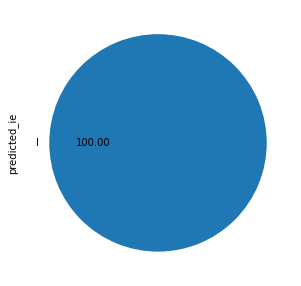

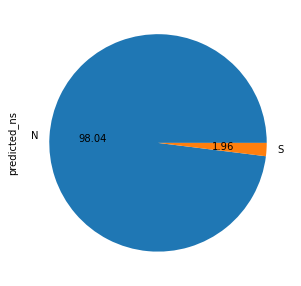

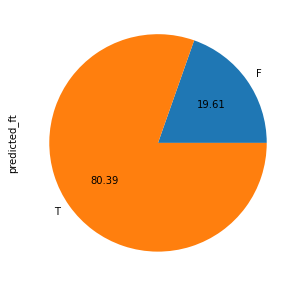

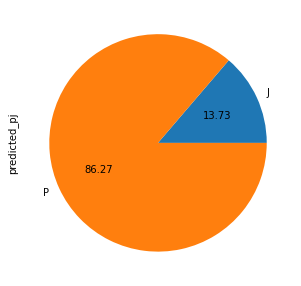

In [ ]:
plt.figure(0)
lloyd_df.groupby('predicted_ie')['predicted_ie'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(1)
lloyd_df.groupby('predicted_ns')['predicted_ns'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(2)
lloyd_df.groupby('predicted_ft')['predicted_ft'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(3)
lloyd_df.groupby('predicted_pj')['predicted_pj'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.show() #show all figures

<Figure size 432x288 with 0 Axes>

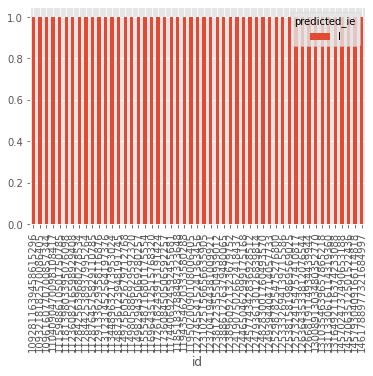

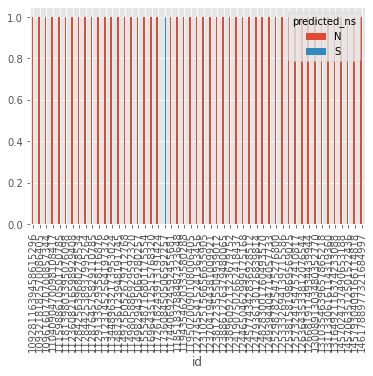

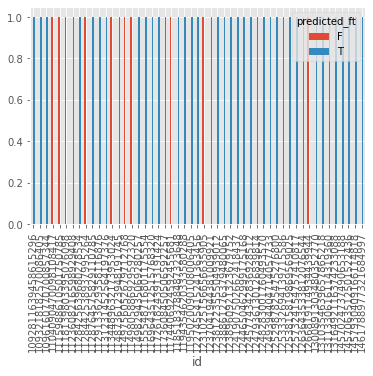

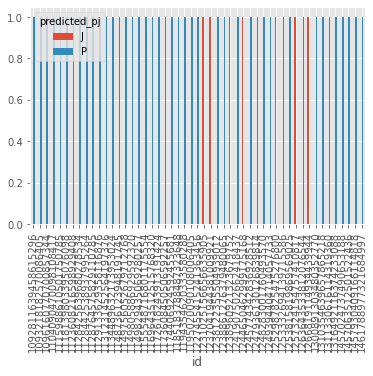

In [ ]:
plt.style.use('ggplot')

plt.figure(0)
lloyd_df.groupby(['id','predicted_ie']).predicted_ie.count().unstack().plot.bar(legend=True)

plt.figure(1)
lloyd_df.groupby(['id','predicted_ns']).predicted_ns.count().unstack().plot.bar(legend=True)

plt.figure(2)
lloyd_df.groupby(['id','predicted_ft']).predicted_ft.count().unstack().plot.bar(legend=True)

plt.figure(3)
lloyd_df.groupby(['id','predicted_pj']).predicted_pj.count().unstack().plot.bar(legend=True)

plt.show() #show all figures

#**10. Decision Tree**

In [ ]:
model_tree=DecisionTreeClassifier(max_depth=14)

In [ ]:
dt =  model_tree.fit(xTrain, nyTrain)
ieModel = model_tree.fit(xIETrain, yIETrain)
nsModel =  model_tree.fit(xNSTrain, yNSTrain)
ftModel =  model_tree.fit(xFTTrain, yFTTrain)
pjModel =  model_tree.fit(xPJTrain, yPJTrain)

In [ ]:
dt.score(xTrain, nyTrain)

0.6230547550432277

In [ ]:
print(dt.score(xTest, nyTest))
print(ieModel.score(xIETest, yIETest))
print(nsModel.score(xNSTest, yNSTest))
print(ftModel.score(xFTTest, yFTTest))
print(pjModel.score(xPJTest, yPJTest))

0.05405405405405406


In [ ]:
print('Train Classification Report \n ',classification_report(nyTrain,dt.predict(xTrain)))

Train Classification Report 
                precision    recall  f1-score   support

           0       0.69      0.37      0.48       190
           1       0.87      0.59      0.70       675
           2       0.73      0.39      0.51       231
           3       0.86      0.57      0.69       685
           4       0.93      0.33      0.49        42
           5       1.00      0.29      0.45        48
           6       0.77      0.26      0.38        39
           7       0.75      0.47      0.58        89
           8       0.68      0.61      0.64      1470
           9       0.59      0.75      0.66      1832
          10       0.79      0.53      0.64      1091
          11       0.41      0.79      0.54      1304
          12       0.96      0.29      0.44       166
          13       0.97      0.41      0.58       271
          14       0.81      0.53      0.64       205
          15       0.89      0.62      0.73       337

    accuracy                           0.62      

In [ ]:
scores = []

scores.append(cross_val_score(estimator=dt, cv=5, X=xTest, y=t_y, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTest, y=t_yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTest, y=t_yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTest, y=t_yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTest, y=t_yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.08214285714285714
0.06738557951469003

0.45357142857142857
0.18126539343499315

0.4892857142857142
0.14965947742683544

0.5071428571428571
0.13199799008983093

0.8357142857142857
0.06123724356957944



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

